In [1]:
# %matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import preps, opts, params, feats, strats
importlib.reload(preps)
importlib.reload(opts)
importlib.reload(params)
importlib.reload(feats)
importlib.reload(strats)

<module 'libs.strats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/strats.py'>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import math
import pandas as pd
from pandas import Timestamp
import numpy as np

import glob
import datetime as dt
from datetime import datetime

import optuna
from optuna.samplers import TPESampler
from optuna.trial import TrialState
from optuna.importance import get_param_importances
from optuna.visualization.matplotlib import plot_optimization_history

from datetime import time
import json
import re
from re import findall

from IPython.display import display, clear_output, update_display, HTML
import io
import os
import json
import contextlib
from tqdm import tqdm

pd.set_option('display.max_columns', None)


,open,high,low,close,volume,trade_count,vwap,ask,bid,rsi_6,atr_14,adx_14,vwap_ohlc_close_session
2021-09-01 08:00:00,152.340,152.400,152.200,152.310,2052.0,79.0,152.343289,152.3405,152.2795,97.117392,0.053679,19.072892,152.310000
2021-09-01 08:01:00,152.310,152.310,152.310,152.310,1163.0,12.0,152.310000,152.3405,152.2795,97.117392,0.049844,23.632803,152.310000
2021-09-01 08:02:00,152.300,152.300,152.300,152.300,900.0,32.5,152.300000,152.3305,152.2695,94.266696,0.046998,27.633299,152.307813
2021-09-01 08:03:00,152.290,152.290,152.290,152.290,637.0,53.0,152.290000,152.3205,152.2595,91.059251,0.044356,31.105532,152.305425
2021-09-01 08:04:00,152.310,152.310,152.290,152.290,582.0,20.0,152.298281,152.3205,152.2595,91.059251,0.042616,34.396121,152.303742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 23:55:00,146.925,146.925,146.925,146.925,420.0,15.5,146.925000,146.9544,146.8956,41.862048,0.031785,20.469780,147.712166
2023-02-28 23:56:00,146.890,146.890,146.890,146.890,296.0,14.0,146.890000,146.9194,146.8606,33.559533,0.032014,20.411414,147.712162
2023-02-28 23:57:00,146.910,146.910,146.910,146.910,326.0,20.0,146.910000,146.9394,146.8806,41.513568,0.031156,19.854952,147.712158
2023-02-28 23:58:00,146.900,146.920,146.900,146.900,7297.0,29.0,146.900371,146.9294,146.8706,38.731484,0.030359,19.338237,147.712062


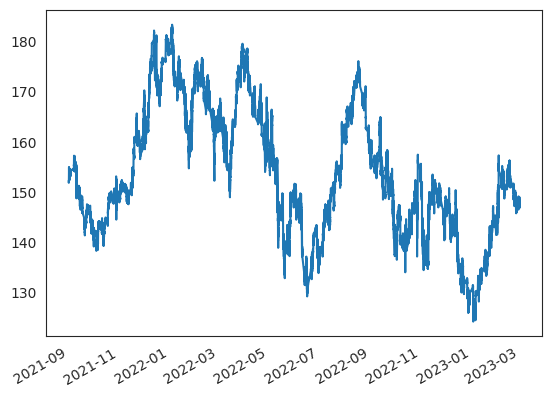

In [3]:
# loading csv with indicators unscaled

hdr = pd.read_csv(params.indunsc_csv, nrows=0).columns.tolist()
index_name = hdr[0]   # first column header, whatever it is

cols_needed = [
    "open","high","low","close","volume","trade_count","vwap","ask","bid",
    params.col_atr_tick, params.col_adx_tick, params.col_rsi_tick, params.col_vwap_tick,
]

usecols = [index_name] + cols_needed

df_inds = pd.read_csv(params.indunsc_csv, usecols=usecols, index_col=index_name, parse_dates=True)
df_inds = df_inds[(df_inds.index >= '2021-09-01') & (df_inds.index < '2023-03-01')] #########################
df_inds.close.plot()
df_inds

In [4]:
# # propose adjusted parameters ranges for next optuna run

# new_ranges = opts.propose_ranges_from_top(
#     csv_path="optuna_results/AAPL_263893648350.5152_target.csv",
#     top_n=25,
#     spread=5.0,
#     agg="median",
#     cat_top_k=3,
# )

# new_ranges

In [5]:
prun_perc       = 80
report_interval = 50

def objective(trial: optuna.Trial) -> float:
    
    min_prof_thr    = trial.suggest_float("min_prof_thr", 0.01, 0.02)      # median ~0.12
    max_down_prop   = trial.suggest_float("max_down_prop", 0.005, 0.01)     # median ~0.12
    gain_tightfact  = trial.suggest_float("gain_tightfact", 0.06, 0.07)   # median ~0.033
    tau_time        = trial.suggest_float("tau_time", 10, 11)          # median ~25.4 (narrow)
    tau_dur         = trial.suggest_float("tau_dur", 8, 9.5)          # median ~45, allow wider spread
    
    thresh_mode     = trial.suggest_categorical("thresh_mode",
                           ["median_nonzero"])
    thresh_window   = (trial.suggest_int("thresh_window", 10, 100)
                       if "roll" in thresh_mode else None)
    
    reset_peak     = trial.suggest_categorical("reset_peak", [False])
    rsi_min_thresh = trial.suggest_int("rsi_min_thresh", 0, 2)            # median ~9
    rsi_max_thresh = trial.suggest_int("rsi_max_thresh", max(rsi_min_thresh + 1, 65), 90)          # median ~89
    adx_thresh     = trial.suggest_float("adx_thresh", 8.5, 10)          # median ~10.5
    atr_mult       = trial.suggest_float("atr_mult", 0.3, 0.45)             # median ~1.4–1.6
    vwap_atr_mult  = trial.suggest_float("vwap_atr_mult", -2.5, -2)       # many good trials negative; allow some positive
    buy_factor     = trial.suggest_float("buy_factor", 0.01, 0.025)         # median ~0.45
    sell_factor    = trial.suggest_float("sell_factor", 0.01, 0.05)        # median ~0.05–0.10
    trailstop_pct  = trial.suggest_float("trailstop_pct", 17, 27)        # median ~3.0

    print("-" * 160)
    print("Params => " + "; ".join(f"{k}={v}" for k, v in dict(trial.params).items()))

    # Build signals for this trial
    df = preps.build_signal_per_day(
        df              = df_inds.copy(),
        min_prof_thr    = min_prof_thr,
        max_down_prop   = max_down_prop,
        gain_tightfact  = gain_tightfact,
        tau_time        = tau_time,
        tau_dur         = tau_dur,
        thresh_mode     = thresh_mode,
        thresh_window   = thresh_window,
    )

    # Group per-day for this trial
    groups_list = list(df.groupby(df.index.normalize()))

    # Reset globals
    start_ask = df.loc[df.index.normalize() == df.index.normalize().min(), "ask"].iat[0]
    strats.reset_globals(start_ask)

    daily_pnls, daily_bh_pnls = [], []
    trial_action_counts = {"Buy": 0, "Sell": 0, "Hold": 0}

    pbar = tqdm(groups_list, desc=f"Trial {trial.number}", leave=True)
    for step, (day, df_day) in enumerate(pbar, 1):
        df_actions = strats.generate_actions_alpaca(
            df              = df_day,
            col_signal      = "signal_raw",
            sign_thresh     = "signal_thresh",
            col_atr         = params.col_atr_tick,
            col_adx         = params.col_adx_tick,
            col_rsi         = params.col_rsi_tick,
            col_vwap        = params.col_vwap_tick,
            reset_peak      = reset_peak,
            rsi_min_thresh  = rsi_min_thresh,
            rsi_max_thresh  = rsi_max_thresh,
            adx_thresh      = adx_thresh,
            atr_mult        = atr_mult,
            vwap_atr_mult   = vwap_atr_mult,
            trailstop_pct   = trailstop_pct,
        )

        sim_results = strats.simulate_trading(
            day         = day,
            df          = df_actions,
            buy_factor  = buy_factor,
            sell_factor = sell_factor,
        )

        df_sim, trades, stats = next(iter(sim_results.values()))

        trial_action_counts["Buy"]  += int((df_sim["Action"] == "Buy").sum())
        trial_action_counts["Sell"] += int((df_sim["Action"] == "Sell").sum())
        trial_action_counts["Hold"] += int((df_sim["Action"] == "Hold").sum())

        daily_pnls.append(strats._parse_eq_value(stats["STRATEGY"]))
        daily_bh_pnls.append(strats._parse_eq_value(stats["BUYNHOLD"]))

        if step % report_interval == 0:
            report_step = step // report_interval
            prun_val = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))

            trial.set_user_attr("mean_pnl",      float(np.mean(daily_pnls)))
            trial.set_user_attr("mean_bh_pnls",  float(np.mean(daily_bh_pnls)))
            trial.set_user_attr("action_counts", {k: int(v) for k, v in trial_action_counts.items()})

            trial.report(prun_val, report_step)
            if trial.should_prune():
                vals = [
                    t.intermediate_values[report_step]
                    for t in trial.study.get_trials(deepcopy=False)
                    if t.state == TrialState.COMPLETE and report_step in t.intermediate_values
                ]
                thr = np.percentile(vals, prun_perc) if vals else prun_val
                print(f"[PRUNE] value={prun_val:.6f} thr={thr:.6f}")
                pbar.close()
                raise optuna.TrialPruned()

    trial.set_user_attr("mean_pnl",     float(np.mean(daily_pnls)))
    trial.set_user_attr("mean_bh_pnls", float(np.mean(daily_bh_pnls)))
    trial.set_user_attr("action_counts",{k: int(v) for k, v in trial_action_counts.items()})

    mean_excess = float(np.mean(np.array(daily_pnls) - np.array(daily_bh_pnls)))
    return mean_excess



Baseline mean daily B&H: -9.5162


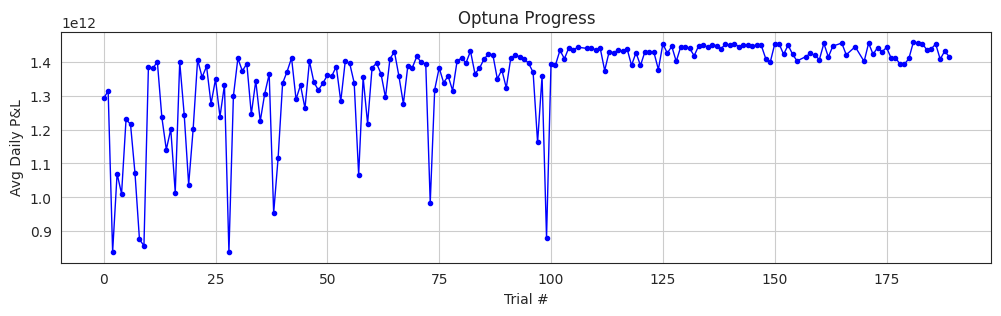

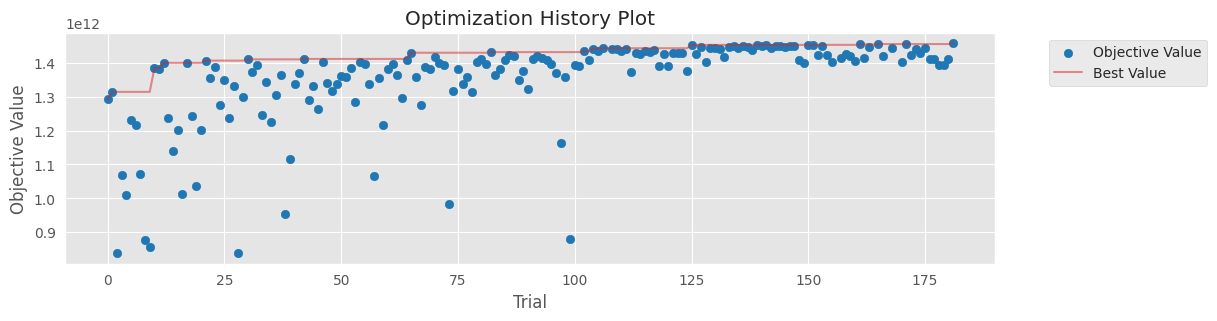

----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017568332625907138; max_down_prop=0.007602161251593872; gain_tightfact=0.06774483684072764; tau_time=10.1139851634471; tau_dur=8.428217894826107; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=67; adx_thresh=9.4523578748244; atr_mult=0.3450037711682845; vwap_atr_mult=-2.0656778564484335; buy_factor=0.01791204693750448; sell_factor=0.028715440899647587; trailstop_pct=18.502829459428586


Trial 0: 100%|██████████| 375/375 [01:01<00:00,  6.06it/s]


[Results] mean_pnl:1291545844411.0483 mean_bh:-8.7491 mean_excess:1291545844419.7971 improv_vs_bh:14762058065536.87%
Action counts: {'Buy': 44818, 'Sell': 73192, 'Hold': 232701}
Best trial is: 0 with best_val: 1291545844419.7971
[save_results] wrote optuna_results/AAPL_1291545844419.797_target.csv
[save_best_json] wrote optuna_results/AAPL_1291545844419.797_target.json
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012620675540372732; max_down_prop=0.009131724588329707; gain_tightfact=0.06168427792765331; tau_time=10.057349040105155; tau_dur=8.637433504148165; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=9.827283397767747; atr_mult=0.3185376945541522; vwap_atr_mult=-2.2941155282113503; buy_factor=0.01830400285883597; sell_factor=0.042848351010617396; trailstop_pct=20.981085497721637


Trial 1: 100%|██████████| 375/375 [00:48<00:00,  7.80it/s]


[Results] mean_pnl:1313861932051.6033 mean_bh:-8.7491 mean_excess:1313861932060.3523 improv_vs_bh:15017125574730.46%
Action counts: {'Buy': 45283, 'Sell': 73296, 'Hold': 232132}
Best trial is: 1 with best_val: 1313861932060.3523
[save_results] wrote optuna_results/AAPL_1313861932060.3523_target.csv
[save_best_json] wrote optuna_results/AAPL_1313861932060.3523_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010494856431544767; max_down_prop=0.006095283474576834; gain_tightfact=0.06153674526340727; tau_time=10.901194244184026; tau_dur=9.184669415910292; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=67; adx_thresh=9.536186055769502; atr_mult=0.38329095185310913; vwap_atr_mult=-2.082494100814937; buy_factor=0.0171420611658943; sell_factor=0.04388698339259465; trailstop_pct=20.085376492719185


Trial 2: 100%|██████████| 375/375 [00:56<00:00,  6.61it/s]


[Results] mean_pnl:839573489391.6287 mean_bh:-8.7491 mean_excess:839573489400.3777 improv_vs_bh:9596122858791.34%
Action counts: {'Buy': 44487, 'Sell': 72612, 'Hold': 233612}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010099657406875734; max_down_prop=0.005992053670260893; gain_tightfact=0.06952202185667117; tau_time=10.460814246768226; tau_dur=8.647515465703108; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=77; adx_thresh=8.61855131127774; atr_mult=0.355661434325252; vwap_atr_mult=-2.394680066543482; buy_factor=0.02071024637508758; sell_factor=0.04071211173149966; trailstop_pct=23.39554009953703


Trial 3: 100%|██████████| 375/375 [00:48<00:00,  7.69it/s]


[Results] mean_pnl:1069795724634.5031 mean_bh:-8.7491 mean_excess:1069795724643.2520 improv_vs_bh:12227507582234.70%
Action counts: {'Buy': 45296, 'Sell': 73298, 'Hold': 232117}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01851369546835011; max_down_prop=0.007170426799128916; gain_tightfact=0.060336020772103656; tau_time=10.669904854008914; tau_dur=8.587468453047972; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=9.59581103372816; atr_mult=0.4391269318734561; vwap_atr_mult=-2.3045193363493004; buy_factor=0.012486475422801815; sell_factor=0.011421496777693956; trailstop_pct=17.72742880280836


Trial 4: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


[Results] mean_pnl:1010760604278.3470 mean_bh:-8.7491 mean_excess:1010760604287.0959 improv_vs_bh:11552750369109.96%
Action counts: {'Buy': 44976, 'Sell': 73001, 'Hold': 232734}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014293344582055743; max_down_prop=0.00558224092009689; gain_tightfact=0.0618626621048619; tau_time=10.156246473163629; tau_dur=9.316563159192656; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; adx_thresh=9.536740368306878; atr_mult=0.39630446604856884; vwap_atr_mult=-2.2868872063146894; buy_factor=0.01748672903489382; sell_factor=0.04191778042766089; trailstop_pct=24.81062807555417


Trial 5: 100%|██████████| 375/375 [00:51<00:00,  7.34it/s]


[Results] mean_pnl:1229931963491.8372 mean_bh:-8.7491 mean_excess:1229931963500.5859 improv_vs_bh:14057826240006.08%
Action counts: {'Buy': 44727, 'Sell': 72861, 'Hold': 233123}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010937192812206774; max_down_prop=0.006734630954355545; gain_tightfact=0.06332797130670463; tau_time=10.20789479542008; tau_dur=8.63151659171556; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=88; adx_thresh=9.751638208215645; atr_mult=0.33557428021529595; vwap_atr_mult=-2.128513483902174; buy_factor=0.011802892231206685; sell_factor=0.03194058548409787; trailstop_pct=23.89637735566443


Trial 6: 100%|██████████| 375/375 [00:44<00:00,  8.45it/s]


[Results] mean_pnl:1215509014321.7917 mean_bh:-8.7491 mean_excess:1215509014330.5408 improv_vs_bh:13892975403278.60%
Action counts: {'Buy': 45227, 'Sell': 73268, 'Hold': 232216}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018758665524200697; max_down_prop=0.005288028009933027; gain_tightfact=0.06685921475335053; tau_time=10.502254841172105; tau_dur=9.171643284165649; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=9.775740245677667; atr_mult=0.3019724673933398; vwap_atr_mult=-2.022971814123589; buy_factor=0.012490183433704836; sell_factor=0.022920139525319266; trailstop_pct=19.131259966207978


Trial 7: 100%|██████████| 375/375 [00:42<00:00,  8.77it/s]


[Results] mean_pnl:1071405294232.8447 mean_bh:-8.7491 mean_excess:1071405294241.5935 improv_vs_bh:12245904575244.20%
Action counts: {'Buy': 45065, 'Sell': 73050, 'Hold': 232596}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011920113166370854; max_down_prop=0.006724889016680403; gain_tightfact=0.06393290646594976; tau_time=10.86377647248271; tau_dur=8.721571700278032; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=66; adx_thresh=8.693394720204044; atr_mult=0.35097401449233767; vwap_atr_mult=-2.19710967579846; buy_factor=0.020554784893171883; sell_factor=0.04094386445749777; trailstop_pct=26.56898751344179


Trial 8: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


[Results] mean_pnl:876407236035.5012 mean_bh:-8.7491 mean_excess:876407236044.2500 improv_vs_bh:10017123715305.56%
Action counts: {'Buy': 44647, 'Sell': 72990, 'Hold': 233074}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017764447583326425; max_down_prop=0.008906668539828348; gain_tightfact=0.06649187925256622; tau_time=10.875295583491926; tau_dur=8.970247525188945; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=9.742755975145343; atr_mult=0.43642070687383583; vwap_atr_mult=-2.1045428293781088; buy_factor=0.016879301866439114; sell_factor=0.047569498936474074; trailstop_pct=20.301926128083593


Trial 9: 100%|██████████| 375/375 [00:41<00:00,  9.02it/s]


[Results] mean_pnl:857501752922.5952 mean_bh:-8.7491 mean_excess:857501752931.3444 improv_vs_bh:9801038594769.16%
Action counts: {'Buy': 44991, 'Sell': 72205, 'Hold': 233515}
Best trial is: 1 with best_val: 1313861932060.3523
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014174314204818746; max_down_prop=0.00960013363761815; gain_tightfact=0.06514781412941328; tau_time=10.016153992766194; tau_dur=8.215287462658381; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=9.092410879474638; atr_mult=0.3007218912394514; vwap_atr_mult=-2.496661137877304; buy_factor=0.023513458545279205; sell_factor=0.03358255811804051; trailstop_pct=21.70662906599441


Trial 10: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1383115594124.2915 mean_bh:-8.7491 mean_excess:1383115594133.0408 improv_vs_bh:15808678259588.77%
Action counts: {'Buy': 45550, 'Sell': 73686, 'Hold': 231475}
Best trial is: 10 with best_val: 1383115594133.0408
[save_results] wrote optuna_results/AAPL_1383115594133.0408_target.csv
[save_best_json] wrote optuna_results/AAPL_1383115594133.0408_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013690835811209945; max_down_prop=0.009993401894407512; gain_tightfact=0.06488488023041385; tau_time=10.023271761242034; tau_dur=8.108112483838669; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=9.006406657024717; atr_mult=0.3023073434539964; vwap_atr_mult=-2.4795814399834466; buy_factor=0.024221957437202013; sell_factor=0.033391134928991595; trailstop_pct=21.73524387324401


Trial 11: 100%|██████████| 375/375 [00:34<00:00, 10.78it/s]


[Results] mean_pnl:1380751606469.7622 mean_bh:-8.7491 mean_excess:1380751606478.5112 improv_vs_bh:15781658449821.16%
Action counts: {'Buy': 45591, 'Sell': 73773, 'Hold': 231347}
Best trial is: 10 with best_val: 1383115594133.0408
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01538883433499642; max_down_prop=0.009998154819551484; gain_tightfact=0.06504275757513948; tau_time=10.000607013721686; tau_dur=8.032012827380552; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=9.017550435148125; atr_mult=0.30288518100096723; vwap_atr_mult=-2.495351299883027; buy_factor=0.02469877243908153; sell_factor=0.03319960899827155; trailstop_pct=22.015056201280046


Trial 12: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1399375129059.0591 mean_bh:-8.7491 mean_excess:1399375129067.8081 improv_vs_bh:15994520829453.95%
Action counts: {'Buy': 45591, 'Sell': 73717, 'Hold': 231403}
Best trial is: 12 with best_val: 1399375129067.8081
[save_results] wrote optuna_results/AAPL_1399375129067.808_target.csv
[save_best_json] wrote optuna_results/AAPL_1399375129067.808_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01586164391489457; max_down_prop=0.009995067260251985; gain_tightfact=0.06532782165829418; tau_time=10.268446655003101; tau_dur=8.001791010713992; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.964112150702519; atr_mult=0.32295891186037623; vwap_atr_mult=-2.486654975344652; buy_factor=0.02480706738768804; sell_factor=0.023678049159458793; trailstop_pct=22.53722370139906


Trial 13: 100%|██████████| 375/375 [00:36<00:00, 10.21it/s]


[Results] mean_pnl:1236535466727.6841 mean_bh:-8.7491 mean_excess:1236535466736.4331 improv_vs_bh:14133302692216.20%
Action counts: {'Buy': 45583, 'Sell': 73654, 'Hold': 231474}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015725406167980207; max_down_prop=0.008579072602077291; gain_tightfact=0.06551666199591503; tau_time=10.383428280174396; tau_dur=8.151486221934526; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=73; adx_thresh=9.170381280065422; atr_mult=0.40922364741343065; vwap_atr_mult=-2.438801606577979; buy_factor=0.022603666064522875; sell_factor=0.03544944988493579; trailstop_pct=22.23407427703668


Trial 14: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1141068525339.7461 mean_bh:-8.7491 mean_excess:1141068525348.4949 improv_vs_bh:13042138535560.93%
Action counts: {'Buy': 45149, 'Sell': 73050, 'Hold': 232512}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01640966367973406; max_down_prop=0.008078583422035109; gain_tightfact=0.0683565653171867; tau_time=10.310904801228354; tau_dur=8.34825764586282; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=8.867357963786505; atr_mult=0.3688598236335058; vwap_atr_mult=-2.3917232893834264; buy_factor=0.022211173988500397; sell_factor=0.024336067098894364; trailstop_pct=24.95301426044388


Trial 15: 100%|██████████| 375/375 [00:35<00:00, 10.43it/s]


[Results] mean_pnl:1200674890898.3252 mean_bh:-8.7491 mean_excess:1200674890907.0742 improv_vs_bh:13723424943823.62%
Action counts: {'Buy': 45439, 'Sell': 73434, 'Hold': 231838}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019974596866630293; max_down_prop=0.009501785925471469; gain_tightfact=0.06344829054238901; tau_time=10.648221111614685; tau_dur=8.296970900770079; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.270047049235137; atr_mult=0.32137597312985833; vwap_atr_mult=-2.368746123101293; buy_factor=0.022510110947821436; sell_factor=0.014770167737764971; trailstop_pct=21.125728203877138


Trial 16: 100%|██████████| 375/375 [00:34<00:00, 10.78it/s]


[Results] mean_pnl:1014400024496.2112 mean_bh:-8.7491 mean_excess:1014400024504.9598 improv_vs_bh:11594348066019.54%
Action counts: {'Buy': 45167, 'Sell': 73223, 'Hold': 232321}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0144639690842623; max_down_prop=0.008475315611896753; gain_tightfact=0.06441073174111861; tau_time=10.019932187476652; tau_dur=8.217618289876242; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=9.21011515842282; atr_mult=0.30023452738592826; vwap_atr_mult=-2.4936665878986766; buy_factor=0.014458121204617065; sell_factor=0.03721283777113229; trailstop_pct=23.180020945975585


Trial 17: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1399171118624.1116 mean_bh:-8.7491 mean_excess:1399171118632.8606 improv_vs_bh:15992189039297.46%
Action counts: {'Buy': 45532, 'Sell': 73576, 'Hold': 231603}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016690082110812906; max_down_prop=0.008384053805599279; gain_tightfact=0.06396685698736508; tau_time=10.184410548030522; tau_dur=8.910053484386243; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=85; adx_thresh=9.297125050806523; atr_mult=0.3279596271695963; vwap_atr_mult=-2.3491954550870005; buy_factor=0.014769922620407426; sell_factor=0.0373555974814552; trailstop_pct=23.481144172767618


Trial 18: 100%|██████████| 375/375 [00:41<00:00,  9.06it/s]


[Results] mean_pnl:1243831941733.4094 mean_bh:-8.7491 mean_excess:1243831941742.1587 improv_vs_bh:14216699644924.94%
Action counts: {'Buy': 45363, 'Sell': 73161, 'Hold': 232187}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012967492444683724; max_down_prop=0.007865179994963415; gain_tightfact=0.06267832383487033; tau_time=10.579821564340124; tau_dur=8.47091035223089; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=9.362234493052677; atr_mult=0.31323192786048454; vwap_atr_mult=-2.4362136892991746; buy_factor=0.010411361459566008; sell_factor=0.0498176970814492; trailstop_pct=25.74870805359167


Trial 19: 100%|██████████| 375/375 [00:49<00:00,  7.55it/s]


[Results] mean_pnl:1037954701743.3185 mean_bh:-8.7491 mean_excess:1037954701752.0675 improv_vs_bh:11863572356228.91%
Action counts: {'Buy': 44994, 'Sell': 73117, 'Hold': 232600}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014844851980109229; max_down_prop=0.008986280697519921; gain_tightfact=0.06641379961504652; tau_time=10.341839842581296; tau_dur=8.0085711703549; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=8.807589460986124; atr_mult=0.36761797946563857; vwap_atr_mult=-2.221770446698611; buy_factor=0.01499085521313124; sell_factor=0.02804682350270872; trailstop_pct=22.96848529019885


Trial 20: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1201105772655.8862 mean_bh:-8.7491 mean_excess:1201105772664.6353 improv_vs_bh:13728349818578.91%
Action counts: {'Buy': 45538, 'Sell': 73472, 'Hold': 231701}
Best trial is: 12 with best_val: 1399375129067.8081
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01400131011420999; max_down_prop=0.009495548290589262; gain_tightfact=0.06480220592664396; tau_time=10.006691959067973; tau_dur=8.223999208736148; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=9.1211500893193; atr_mult=0.30644428756932146; vwap_atr_mult=-2.4921297899869366; buy_factor=0.014917597145548184; sell_factor=0.037198346434395076; trailstop_pct=21.7427820946288


Trial 21: 100%|██████████| 375/375 [00:46<00:00,  8.15it/s]


[Results] mean_pnl:1406013141273.4729 mean_bh:-8.7491 mean_excess:1406013141282.2217 improv_vs_bh:16070391710981.15%
Action counts: {'Buy': 45524, 'Sell': 73585, 'Hold': 231602}
Best trial is: 21 with best_val: 1406013141282.2217
[save_results] wrote optuna_results/AAPL_1406013141282.2217_target.csv
[save_best_json] wrote optuna_results/AAPL_1406013141282.2217_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01506006991399615; max_down_prop=0.009441653628411128; gain_tightfact=0.0646351227398795; tau_time=10.08462008138487; tau_dur=8.237392786590327; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=9.117352040195827; atr_mult=0.3356685068931011; vwap_atr_mult=-2.4358494610828205; buy_factor=0.014709829832223065; sell_factor=0.037395815460658434; trailstop_pct=24.53964354277491


Trial 22: 100%|██████████| 375/375 [00:35<00:00, 10.52it/s]


[Results] mean_pnl:1354161753038.6626 mean_bh:-8.7491 mean_excess:1354161753047.4116 improv_vs_bh:15477742826539.25%
Action counts: {'Buy': 45519, 'Sell': 73463, 'Hold': 231729}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01320367201960144; max_down_prop=0.0086813881961781; gain_tightfact=0.06626094348632593; tau_time=10.00875789172024; tau_dur=8.450593428224765; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=8.921867171625614; atr_mult=0.3113855814701786; vwap_atr_mult=-2.4468859829604686; buy_factor=0.01575297893542667; sell_factor=0.03829961547487986; trailstop_pct=19.94196874402435


Trial 23: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1386203722919.7078 mean_bh:-8.7491 mean_excess:1386203722928.4568 improv_vs_bh:15843974828261.70%
Action counts: {'Buy': 45566, 'Sell': 73588, 'Hold': 231557}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012038345533775465; max_down_prop=0.009339431337756053; gain_tightfact=0.062598621429514; tau_time=10.20609942433869; tau_dur=8.117760492120595; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=9.179935872408471; atr_mult=0.3371125015046533; vwap_atr_mult=-2.4940512086543682; buy_factor=0.013908180339274498; sell_factor=0.03016177973988894; trailstop_pct=21.0088388039619


Trial 24: 100%|██████████| 375/375 [00:40<00:00,  9.35it/s]


[Results] mean_pnl:1275709024429.0950 mean_bh:-8.7491 mean_excess:1275709024437.8438 improv_vs_bh:14581047025814.88%
Action counts: {'Buy': 45575, 'Sell': 73661, 'Hold': 231475}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015091018885463986; max_down_prop=0.009674261441849215; gain_tightfact=0.06436048502131549; tau_time=10.097420782434531; tau_dur=8.325160015347231; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.760356090851204; atr_mult=0.31203353630652597; vwap_atr_mult=-2.402570471410504; buy_factor=0.019030714665759736; sell_factor=0.020088704220093987; trailstop_pct=22.70037034935434


Trial 25: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1348007484334.3694 mean_bh:-8.7491 mean_excess:1348007484343.1184 improv_vs_bh:15407401016872.78%
Action counts: {'Buy': 45519, 'Sell': 73794, 'Hold': 231398}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013889222011541386; max_down_prop=0.008077916697945152; gain_tightfact=0.06589690459069607; tau_time=10.266221014069709; tau_dur=8.099190632052899; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.527220940949531; atr_mult=0.3001229943621896; vwap_atr_mult=-2.3285402960396606; buy_factor=0.016223006801567186; sell_factor=0.04623251377083161; trailstop_pct=24.008569482688635


Trial 26: 100%|██████████| 375/375 [00:42<00:00,  8.82it/s]


[Results] mean_pnl:1237793999406.6531 mean_bh:-8.7491 mean_excess:1237793999415.4021 improv_vs_bh:14147687417748.46%
Action counts: {'Buy': 45655, 'Sell': 73553, 'Hold': 231503}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015833313417310545; max_down_prop=0.008429736908212837; gain_tightfact=0.06753174499699226; tau_time=10.132624415613531; tau_dur=8.001457552534617; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.016571676673681; atr_mult=0.4208926402332176; vwap_atr_mult=-2.456714691160921; buy_factor=0.013377500101326392; sell_factor=0.026560834571629187; trailstop_pct=21.87265682704626


Trial 27: 100%|██████████| 375/375 [00:39<00:00,  9.39it/s]


[Results] mean_pnl:1331268050509.4854 mean_bh:-8.7491 mean_excess:1331268050518.2346 improv_vs_bh:15216073318227.94%
Action counts: {'Buy': 45562, 'Sell': 73278, 'Hold': 231871}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01681375617418352; max_down_prop=0.009071398494019167; gain_tightfact=0.06297195501581604; tau_time=10.98918718734357; tau_dur=8.508079768050933; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=9.392114472474866; atr_mult=0.32754083981771226; vwap_atr_mult=-2.410135594615051; buy_factor=0.019861897874413698; sell_factor=0.0314482403398223; trailstop_pct=19.148658956453865


Trial 28: 100%|██████████| 375/375 [00:36<00:00, 10.33it/s]


[Results] mean_pnl:838537010822.1743 mean_bh:-8.7491 mean_excess:838537010830.9237 improv_vs_bh:9584276158271.90%
Action counts: {'Buy': 44796, 'Sell': 72781, 'Hold': 233134}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014691047822031887; max_down_prop=0.009833831167378102; gain_tightfact=0.06762410108525957; tau_time=10.100778600963332; tau_dur=8.346347438721033; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=87; adx_thresh=9.998227948031424; atr_mult=0.3476878950824293; vwap_atr_mult=-2.17374623332175; buy_factor=0.01114986975694877; sell_factor=0.03464387569919148; trailstop_pct=17.326001211017978


Trial 29: 100%|██████████| 375/375 [00:43<00:00,  8.62it/s]


[Results] mean_pnl:1298642925772.5061 mean_bh:-8.7491 mean_excess:1298642925781.2549 improv_vs_bh:14843175996895.12%
Action counts: {'Buy': 45149, 'Sell': 73004, 'Hold': 232558}
Best trial is: 21 with best_val: 1406013141282.2217
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015470521008659805; max_down_prop=0.009259780182992025; gain_tightfact=0.06397632849048145; tau_time=10.00395693150889; tau_dur=8.23531346521467; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=9.065289280305365; atr_mult=0.357966403189314; vwap_atr_mult=-2.4612047885211124; buy_factor=0.013432926241460474; sell_factor=0.03883190959601595; trailstop_pct=22.945304499624655


Trial 30: 100%|██████████| 375/375 [00:40<00:00,  9.34it/s]


[Results] mean_pnl:1409750276580.7319 mean_bh:-8.7491 mean_excess:1409750276589.4812 improv_vs_bh:16113106267837.86%
Action counts: {'Buy': 45550, 'Sell': 73396, 'Hold': 231765}
Best trial is: 30 with best_val: 1409750276589.4812
[save_results] wrote optuna_results/AAPL_1409750276589.4812_target.csv
[save_best_json] wrote optuna_results/AAPL_1409750276589.4812_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015526026519321669; max_down_prop=0.009296081715323647; gain_tightfact=0.06426181891669638; tau_time=10.064369481530825; tau_dur=8.229239370175788; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=9.070264501130204; atr_mult=0.3106843403017186; vwap_atr_mult=-2.465463697511763; buy_factor=0.013275660387421834; sell_factor=0.03707856345260211; trailstop_pct=23.07508419088497


Trial 31: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:1372372286259.9966 mean_bh:-8.7491 mean_excess:1372372286268.7454 improv_vs_bh:15685884837122.30%
Action counts: {'Buy': 45571, 'Sell': 73501, 'Hold': 231639}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013500619502527601; max_down_prop=0.008868784209235654; gain_tightfact=0.06563004151935022; tau_time=10.013375823762699; tau_dur=8.19559071706371; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=9.215462683129601; atr_mult=0.36052028865149993; vwap_atr_mult=-2.496301662825717; buy_factor=0.01573096775658493; sell_factor=0.0401586914587764; trailstop_pct=22.27113698063029


Trial 32: 100%|██████████| 375/375 [00:38<00:00,  9.87it/s]


[Results] mean_pnl:1394202807154.1165 mean_bh:-8.7491 mean_excess:1394202807162.8652 improv_vs_bh:15935402435303.02%
Action counts: {'Buy': 45570, 'Sell': 73463, 'Hold': 231678}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012294679962817683; max_down_prop=0.007416656877344344; gain_tightfact=0.06364743846535507; tau_time=10.133000541184249; tau_dur=9.489384246966628; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.872575367216427; atr_mult=0.38962346633330763; vwap_atr_mult=-2.4276024418525566; buy_factor=0.013862274528717768; sell_factor=0.04487398468371008; trailstop_pct=21.419279507846866


Trial 33: 100%|██████████| 375/375 [00:37<00:00,  9.95it/s]


[Results] mean_pnl:1245411172189.9668 mean_bh:-8.7491 mean_excess:1245411172198.7163 improv_vs_bh:14234749868847.92%
Action counts: {'Buy': 45459, 'Sell': 73219, 'Hold': 232033}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01723789099989581; max_down_prop=0.00926679697558496; gain_tightfact=0.06477127527448555; tau_time=10.057105302036328; tau_dur=8.388438728334517; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=9.329548700741107; atr_mult=0.3785999538470677; vwap_atr_mult=-2.3708092959433884; buy_factor=0.018126004806733577; sell_factor=0.03876218250906193; trailstop_pct=20.51038975509333


Trial 34: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1343382907203.5154 mean_bh:-8.7491 mean_excess:1343382907212.2644 improv_vs_bh:15354543213621.60%
Action counts: {'Buy': 45469, 'Sell': 73191, 'Hold': 232051}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014442020977287364; max_down_prop=0.00972800172034101; gain_tightfact=0.06211336426562907; tau_time=10.255047014200908; tau_dur=8.535714367571668; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=9.134048936114855; atr_mult=0.34102613782444685; vwap_atr_mult=-2.4695610383761823; buy_factor=0.01249729993505481; sell_factor=0.04403182671098281; trailstop_pct=24.071778129288578


Trial 35: 100%|██████████| 375/375 [00:36<00:00, 10.19it/s]


[Results] mean_pnl:1224623939780.8206 mean_bh:-8.7491 mean_excess:1224623939789.5693 improv_vs_bh:13997156806881.56%
Action counts: {'Buy': 45431, 'Sell': 73209, 'Hold': 232071}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016342337107202884; max_down_prop=0.008679142854159792; gain_tightfact=0.06696662211726537; tau_time=10.15711645618505; tau_dur=8.081141309016179; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.452202698239015; atr_mult=0.3153928109471016; vwap_atr_mult=-2.2637286055442485; buy_factor=0.016493993714609308; sell_factor=0.028555641262596156; trailstop_pct=25.480327744642075


Trial 36: 100%|██████████| 375/375 [00:39<00:00,  9.40it/s]


[Results] mean_pnl:1305467005651.5283 mean_bh:-8.7491 mean_excess:1305467005660.2773 improv_vs_bh:14921173587033.51%
Action counts: {'Buy': 45480, 'Sell': 73417, 'Hold': 231814}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011340980099338718; max_down_prop=0.009170501431231295; gain_tightfact=0.061452570856126064; tau_time=10.001671953220507; tau_dur=8.842959398774559; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=9.03114615265809; atr_mult=0.3289031276759011; vwap_atr_mult=-2.413609262399391; buy_factor=0.019002269915551196; sell_factor=0.0357069106238689; trailstop_pct=23.415944217550383


Trial 37: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1363228217522.4824 mean_bh:-8.7491 mean_excess:1363228217531.2314 improv_vs_bh:15581370332862.42%
Action counts: {'Buy': 45374, 'Sell': 73649, 'Hold': 231688}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015337359054163507; max_down_prop=0.008128922378039; gain_tightfact=0.06996796077738372; tau_time=10.779336260600617; tau_dur=8.25867122896625; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=9.228011311278816; atr_mult=0.30882956520240806; vwap_atr_mult=-2.461386631461778; buy_factor=0.011393224232395496; sell_factor=0.04263762554971766; trailstop_pct=20.81754399945657


Trial 38: 100%|██████████| 375/375 [00:36<00:00, 10.17it/s]


[Results] mean_pnl:953836754268.6884 mean_bh:-8.7491 mean_excess:953836754277.4371 improv_vs_bh:10902124467763.05%
Action counts: {'Buy': 44826, 'Sell': 73047, 'Hold': 232838}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012698274761711762; max_down_prop=0.007569985683781547; gain_tightfact=0.06419524363391339; tau_time=10.413507249943239; tau_dur=8.4124558653868; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=86; adx_thresh=9.607859031494758; atr_mult=0.39820195327597274; vwap_atr_mult=-2.3173880633675434; buy_factor=0.014205366394425697; sell_factor=0.03169735988572721; trailstop_pct=19.71561990206173


Trial 39: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1117232483312.2488 mean_bh:-8.7491 mean_excess:1117232483320.9976 improv_vs_bh:12769698313649.52%
Action counts: {'Buy': 45209, 'Sell': 73109, 'Hold': 232393}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017826973630820808; max_down_prop=0.007009041803393547; gain_tightfact=0.0609374357577653; tau_time=10.07121887804994; tau_dur=8.167152277731251; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=74; adx_thresh=8.69231691586732; atr_mult=0.35517568327470994; vwap_atr_mult=-2.3584464007395938; buy_factor=0.01752563268877512; sell_factor=0.04018854534808688; trailstop_pct=22.842415043364234


Trial 40: 100%|██████████| 375/375 [00:37<00:00, 10.09it/s]


[Results] mean_pnl:1336360002797.9500 mean_bh:-8.7491 mean_excess:1336360002806.6987 improv_vs_bh:15274273107011.30%
Action counts: {'Buy': 45406, 'Sell': 73241, 'Hold': 232064}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013446808500122911; max_down_prop=0.008956752153470455; gain_tightfact=0.06567735338751489; tau_time=10.049113337978865; tau_dur=8.20314452573311; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=9.2192970515656; atr_mult=0.36581140309995885; vwap_atr_mult=-2.4901163206011043; buy_factor=0.015552170134502203; sell_factor=0.040058848233617834; trailstop_pct=22.27902111262389


Trial 41: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1370612649630.4583 mean_bh:-8.7491 mean_excess:1370612649639.2070 improv_vs_bh:15665772614074.45%
Action counts: {'Buy': 45577, 'Sell': 73412, 'Hold': 231722}
Best trial is: 30 with best_val: 1409750276589.4812
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014117537286547351; max_down_prop=0.008828129227616357; gain_tightfact=0.0659273490129858; tau_time=10.00115288449015; tau_dur=8.07465414243706; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=90; adx_thresh=8.93919814274137; atr_mult=0.3607871527500083; vwap_atr_mult=-2.4628039904964307; buy_factor=0.015450856652088351; sell_factor=0.041805662420196295; trailstop_pct=22.335359436619992


Trial 42: 100%|██████████| 375/375 [00:39<00:00,  9.52it/s]


[Results] mean_pnl:1410942348761.3523 mean_bh:-8.7491 mean_excess:1410942348770.1011 improv_vs_bh:16126731365874.19%
Action counts: {'Buy': 45637, 'Sell': 73414, 'Hold': 231660}
Best trial is: 42 with best_val: 1410942348770.1011
[save_results] wrote optuna_results/AAPL_1410942348770.101_target.csv
[save_best_json] wrote optuna_results/AAPL_1410942348770.101_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0141414426277166; max_down_prop=0.009687539202805717; gain_tightfact=0.06846402971519133; tau_time=10.170523729200951; tau_dur=8.06538839846787; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=88; adx_thresh=8.924102431395474; atr_mult=0.447087406557918; vwap_atr_mult=-2.4650277824192273; buy_factor=0.012537948194580874; sell_factor=0.04224804864131889; trailstop_pct=21.476435633960463


Trial 43: 100%|██████████| 375/375 [00:37<00:00, 10.04it/s]


[Results] mean_pnl:1289215776223.2898 mean_bh:-8.7491 mean_excess:1289215776232.0386 improv_vs_bh:14735425947108.43%
Action counts: {'Buy': 45645, 'Sell': 73140, 'Hold': 231926}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014549732181672229; max_down_prop=0.009533338033427022; gain_tightfact=0.06506156923806193; tau_time=10.110267046642873; tau_dur=8.272386272956417; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=87; adx_thresh=9.055301398213016; atr_mult=0.37945772815051726; vwap_atr_mult=-2.387347358646476; buy_factor=0.013063700735765564; sell_factor=0.033689545506100885; trailstop_pct=23.4717733615913


Trial 44: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1330852915430.0789 mean_bh:-8.7491 mean_excess:1330852915438.8276 improv_vs_bh:15211328424212.97%
Action counts: {'Buy': 45563, 'Sell': 73377, 'Hold': 231771}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014029128851311792; max_down_prop=0.008806646441467595; gain_tightfact=0.0660243963970307; tau_time=10.230369824644375; tau_dur=8.061655692774057; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=89; adx_thresh=8.982427413615792; atr_mult=0.31883357559789394; vwap_atr_mult=-2.4319711721818527; buy_factor=0.01670456607186983; sell_factor=0.03562081588962549; trailstop_pct=21.952707195893424


Trial 45: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1262552871321.0974 mean_bh:-8.7491 mean_excess:1262552871329.8464 improv_vs_bh:14430675363098.87%
Action counts: {'Buy': 45643, 'Sell': 73568, 'Hold': 231500}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016142048237833648; max_down_prop=0.00990234708855256; gain_tightfact=0.06688969977989818; tau_time=10.003653026536696; tau_dur=8.161778939371338; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.79711516429505; atr_mult=0.3064042693104917; vwap_atr_mult=-2.472385137193809; buy_factor=0.01499769370776304; sell_factor=0.0459044795771045; trailstop_pct=24.382356272939816


Trial 46: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1401411532027.4314 mean_bh:-8.7491 mean_excess:1401411532036.1802 improv_vs_bh:16017796425123.92%
Action counts: {'Buy': 45602, 'Sell': 73463, 'Hold': 231646}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0160604717963886; max_down_prop=0.009924161740679754; gain_tightfact=0.06692228706549415; tau_time=10.0522743284813; tau_dur=8.69519116032566; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.740771877618991; atr_mult=0.30600060715832256; vwap_atr_mult=-2.470920721352132; buy_factor=0.015316662470755842; sell_factor=0.046256876055323304; trailstop_pct=24.43344879754114


Trial 47: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1338910715032.3464 mean_bh:-8.7491 mean_excess:1338910715041.0957 improv_vs_bh:15303427133773.35%
Action counts: {'Buy': 45546, 'Sell': 73381, 'Hold': 231784}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0172399573425882; max_down_prop=0.005954741937567587; gain_tightfact=0.06854363323002809; tau_time=10.137453647073848; tau_dur=8.13558264423552; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=8.624742524737867; atr_mult=0.34559142394697984; vwap_atr_mult=-2.006393758410492; buy_factor=0.017193004770479116; sell_factor=0.04875214531128606; trailstop_pct=26.407873730567218


Trial 48: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1316177237550.4263 mean_bh:-8.7491 mean_excess:1316177237559.1753 improv_vs_bh:15043588959178.45%
Action counts: {'Buy': 45595, 'Sell': 73314, 'Hold': 231802}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015306459752703947; max_down_prop=0.009828840351257289; gain_tightfact=0.06727604858170082; tau_time=10.042434220957546; tau_dur=8.580135114719512; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=8.829141318879529; atr_mult=0.3577341638785675; vwap_atr_mult=-2.41502426954101; buy_factor=0.021341927447627404; sell_factor=0.0444870055782816; trailstop_pct=25.160979138076925


Trial 49: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1336283088938.8728 mean_bh:-8.7491 mean_excess:1336283088947.6218 improv_vs_bh:15273394000118.85%
Action counts: {'Buy': 45492, 'Sell': 73371, 'Hold': 231848}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016194611092830522; max_down_prop=0.009458096105220278; gain_tightfact=0.06373591246509122; tau_time=10.087646673030228; tau_dur=8.045729742296125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=8.954950395008343; atr_mult=0.32298970337693933; vwap_atr_mult=-2.4495064688867254; buy_factor=0.011738035895837658; sell_factor=0.04645370051655183; trailstop_pct=23.68748638802644


Trial 50: 100%|██████████| 375/375 [00:37<00:00, 10.07it/s]


[Results] mean_pnl:1359717657969.0776 mean_bh:-8.7491 mean_excess:1359717657977.8269 improv_vs_bh:15541245482324.75%
Action counts: {'Buy': 45624, 'Sell': 73356, 'Hold': 231731}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014592316893768796; max_down_prop=0.009150293884538833; gain_tightfact=0.06517269475427367; tau_time=10.007583908369686; tau_dur=9.108946552135944; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=9.101968110936255; atr_mult=0.3164374198632748; vwap_atr_mult=-2.4996465525144362; buy_factor=0.014486353853591278; sell_factor=0.041974314533349794; trailstop_pct=23.065221080534727


Trial 51: 100%|██████████| 375/375 [00:40<00:00,  9.28it/s]


[Results] mean_pnl:1357604770994.7502 mean_bh:-8.7491 mean_excess:1357604771003.4993 improv_vs_bh:15517095692880.04%
Action counts: {'Buy': 45404, 'Sell': 73313, 'Hold': 231994}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015714728750340096; max_down_prop=0.009573899438136343; gain_tightfact=0.06455344219695111; tau_time=10.043888950046204; tau_dur=8.169461997235684; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=86; adx_thresh=8.871264091492439; atr_mult=0.3051970863122874; vwap_atr_mult=-2.480013181611558; buy_factor=0.013732239423571838; sell_factor=0.03843382833927598; trailstop_pct=22.598777538232536


Trial 52: 100%|██████████| 375/375 [00:39<00:00,  9.41it/s]


[Results] mean_pnl:1385661575448.4419 mean_bh:-8.7491 mean_excess:1385661575457.1904 improv_vs_bh:15837778213185.67%
Action counts: {'Buy': 45585, 'Sell': 73557, 'Hold': 231569}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015045426566848161; max_down_prop=0.009964342173085424; gain_tightfact=0.06323936624432681; tau_time=10.17789176404558; tau_dur=8.28202358923452; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=9.152888375313657; atr_mult=0.30012803494226126; vwap_atr_mult=-2.050738614646228; buy_factor=0.016088912160844435; sell_factor=0.03647368021066985; trailstop_pct=24.517875590430666


Trial 53: 100%|██████████| 375/375 [00:36<00:00, 10.22it/s]


[Results] mean_pnl:1283247028680.3074 mean_bh:-8.7491 mean_excess:1283247028689.0559 improv_vs_bh:14667204599652.03%
Action counts: {'Buy': 45499, 'Sell': 73492, 'Hold': 231720}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013660388472018984; max_down_prop=0.008400143487836355; gain_tightfact=0.06648481983854038; tau_time=10.002208471844284; tau_dur=8.3843365696185; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=9.288369423147179; atr_mult=0.33040861264073; vwap_atr_mult=-2.4760844951247476; buy_factor=0.015331083693124036; sell_factor=0.033337620100486305; trailstop_pct=21.45424085530868


Trial 54: 100%|██████████| 375/375 [00:38<00:00,  9.72it/s]


[Results] mean_pnl:1400757500766.1416 mean_bh:-8.7491 mean_excess:1400757500774.8909 improv_vs_bh:16010321005263.64%
Action counts: {'Buy': 45420, 'Sell': 73587, 'Hold': 231704}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012787993789171568; max_down_prop=0.009356964467190811; gain_tightfact=0.06634561977966988; tau_time=10.002931351770336; tau_dur=8.380631415917536; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=9.283577795713688; atr_mult=0.3722632560418701; vwap_atr_mult=-2.4528957651571783; buy_factor=0.014951359934113484; sell_factor=0.03263742970644389; trailstop_pct=21.363240621921612


Trial 55: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1394748803257.2419 mean_bh:-8.7491 mean_excess:1394748803265.9912 improv_vs_bh:15941643039314.65%
Action counts: {'Buy': 45378, 'Sell': 73514, 'Hold': 231819}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01367380992907933; max_down_prop=0.008309883396210372; gain_tightfact=0.0681447397250158; tau_time=10.107474015694287; tau_dur=8.137242649657573; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.437063136072984; atr_mult=0.33267689016073904; vwap_atr_mult=-2.3849072487688616; buy_factor=0.01525015270226893; sell_factor=0.03011949262704831; trailstop_pct=20.45507517101575


Trial 56: 100%|██████████| 375/375 [00:37<00:00, 10.12it/s]


[Results] mean_pnl:1337485674542.9917 mean_bh:-8.7491 mean_excess:1337485674551.7407 improv_vs_bh:15287139264054.68%
Action counts: {'Buy': 45439, 'Sell': 73508, 'Hold': 231764}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013147934360159671; max_down_prop=0.007828093655169711; gain_tightfact=0.06671438077269179; tau_time=10.527860195643857; tau_dur=8.319856682028847; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=8.91160163341492; atr_mult=0.34181427412630433; vwap_atr_mult=-2.423280828297219; buy_factor=0.023249972436500538; sell_factor=0.03427235985046845; trailstop_pct=20.870485973421854


Trial 57: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1066646963787.7126 mean_bh:-8.7491 mean_excess:1066646963796.4617 improv_vs_bh:12191518003811.57%
Action counts: {'Buy': 45401, 'Sell': 73477, 'Hold': 231833}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016793601384437945; max_down_prop=0.009741560566306692; gain_tightfact=0.06539501647871555; tau_time=10.084510711418794; tau_dur=8.11866316920105; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=9.538069131156217; atr_mult=0.35240562188085706; vwap_atr_mult=-2.477296192371619; buy_factor=0.013069826336077266; sell_factor=0.04128346317432654; trailstop_pct=22.2920389639191


Trial 58: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1353698228511.1018 mean_bh:-8.7491 mean_excess:1353698228519.8506 improv_vs_bh:15472444852781.51%
Action counts: {'Buy': 45421, 'Sell': 73241, 'Hold': 232049}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.012386827013249026; max_down_prop=0.009167777630082159; gain_tightfact=0.0660128963390603; tau_time=10.308779429566313; tau_dur=8.034001249575004; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.790665251136152; atr_mult=0.3242128031406467; vwap_atr_mult=-2.4427069402207464; buy_factor=0.017066425818103713; sell_factor=0.026941925694161362; trailstop_pct=21.75337298059844


Trial 59: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1217123174443.1223 mean_bh:-8.7491 mean_excess:1217123174451.8711 improv_vs_bh:13911424864860.71%
Action counts: {'Buy': 45421, 'Sell': 73821, 'Hold': 231469}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018268244693164692; max_down_prop=0.008769178740151868; gain_tightfact=0.06805854327807027; tau_time=10.034591732395137; tau_dur=8.25972213871215; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=83; adx_thresh=8.6991234127094; atr_mult=0.30658750084262426; vwap_atr_mult=-2.4798739270611128; buy_factor=0.017739040310985204; sell_factor=0.03947924916345866; trailstop_pct=26.96256665675707


Trial 60: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:1382282512937.5193 mean_bh:-8.7491 mean_excess:1382282512946.2683 improv_vs_bh:15799156342186.02%
Action counts: {'Buy': 45620, 'Sell': 73498, 'Hold': 231593}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014195979770640875; max_down_prop=0.008406622286872613; gain_tightfact=0.06489937448263398; tau_time=10.02907921606364; tau_dur=8.170415329350382; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=85; adx_thresh=9.181195527698533; atr_mult=0.316322479147375; vwap_atr_mult=-2.453444306782621; buy_factor=0.01429926546385196; sell_factor=0.03794122511349237; trailstop_pct=23.110202561057374


Trial 61: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1395285236950.9438 mean_bh:-8.7491 mean_excess:1395285236959.6926 improv_vs_bh:15947774347288.70%
Action counts: {'Buy': 45550, 'Sell': 73559, 'Hold': 231602}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01487262756211415; max_down_prop=0.008588014507134895; gain_tightfact=0.06409585092219577; tau_time=10.072674600487339; tau_dur=8.202566634021345; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=81; adx_thresh=9.075020951002744; atr_mult=0.304840786744091; vwap_atr_mult=-2.133831444742188; buy_factor=0.016086513147209772; sell_factor=0.03614108225596918; trailstop_pct=22.50760702343485


Trial 62: 100%|██████████| 375/375 [00:38<00:00,  9.67it/s]


[Results] mean_pnl:1364063598326.3770 mean_bh:-8.7491 mean_excess:1364063598335.1257 improv_vs_bh:15590918534335.25%
Action counts: {'Buy': 45548, 'Sell': 73584, 'Hold': 231579}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.015372734767037587; max_down_prop=0.00898549468275025; gain_tightfact=0.06457956653475984; tau_time=10.13749526587521; tau_dur=8.462488951238845; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=84; adx_thresh=9.357417578017746; atr_mult=0.3105752690016825; vwap_atr_mult=-2.499918269484654; buy_factor=0.014802630730407983; sell_factor=0.04342108526114898; trailstop_pct=23.871308631652497


Trial 63: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1294512307526.1165 mean_bh:-8.7491 mean_excess:1294512307534.8655 improv_vs_bh:14795964024774.10%
Action counts: {'Buy': 45445, 'Sell': 73377, 'Hold': 231889}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013823038246894256; max_down_prop=0.007875789402818167; gain_tightfact=0.0671953051070874; tau_time=10.030978735465611; tau_dur=8.091471001473467; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.998491089253754; atr_mult=0.36414010336437014; vwap_atr_mult=-2.4823575160216134; buy_factor=0.013551121051345998; sell_factor=0.03262103169520945; trailstop_pct=22.044137609852577


Trial 64: 100%|██████████| 375/375 [00:39<00:00,  9.46it/s]


[Results] mean_pnl:1408714575635.4590 mean_bh:-8.7491 mean_excess:1408714575644.2078 improv_vs_bh:16101268455375.61%
Action counts: {'Buy': 45596, 'Sell': 73542, 'Hold': 231573}
Best trial is: 42 with best_val: 1410942348770.1011
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013856537720476549; max_down_prop=0.008180719140261299; gain_tightfact=0.06739090861734018; tau_time=10.004138033615604; tau_dur=8.09023039033613; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.988271665150886; atr_mult=0.36252596364273476; vwap_atr_mult=-2.480338465107138; buy_factor=0.012152460772998435; sell_factor=0.03061689765644559; trailstop_pct=22.05752280391889


Trial 65: 100%|██████████| 375/375 [00:41<00:00,  9.11it/s]


[Results] mean_pnl:1429157746237.4072 mean_bh:-8.7491 mean_excess:1429157746246.1562 improv_vs_bh:16334928973717.64%
Action counts: {'Buy': 45592, 'Sell': 73562, 'Hold': 231557}
Best trial is: 65 with best_val: 1429157746246.1562
[save_results] wrote optuna_results/AAPL_1429157746246.1562_target.csv
[save_best_json] wrote optuna_results/AAPL_1429157746246.1562_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013906208260411737; max_down_prop=0.00785390624888342; gain_tightfact=0.06718296532668096; tau_time=10.119273073118283; tau_dur=8.096122873754862; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=9.006097426336533; atr_mult=0.363764332535041; vwap_atr_mult=-2.4001117422821427; buy_factor=0.010335276754951012; sell_factor=0.03072547986862592; trailstop_pct=21.263787053581943


Trial 66: 100%|██████████| 375/375 [00:42<00:00,  8.92it/s]


[Results] mean_pnl:1357237885576.6965 mean_bh:-8.7491 mean_excess:1357237885585.4456 improv_vs_bh:15512902280878.36%
Action counts: {'Buy': 45606, 'Sell': 73526, 'Hold': 231579}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013457689237065102; max_down_prop=0.008103097291564151; gain_tightfact=0.0689248433000328; tau_time=10.207106784087994; tau_dur=8.28944330632643; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=79; adx_thresh=8.962604178725163; atr_mult=0.37042047630821107; vwap_atr_mult=-2.439967165855374; buy_factor=0.01229883439698835; sell_factor=0.03285326692963354; trailstop_pct=21.5479580168001


Trial 67: 100%|██████████| 375/375 [00:42<00:00,  8.88it/s]


[Results] mean_pnl:1275909765385.2385 mean_bh:-8.7491 mean_excess:1275909765393.9875 improv_vs_bh:14583341446615.75%
Action counts: {'Buy': 45499, 'Sell': 73467, 'Hold': 231745}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01314175003926286; max_down_prop=0.007372317971862971; gain_tightfact=0.06734927655676846; tau_time=10.038000636182742; tau_dur=8.33676737514174; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.831435953912901; atr_mult=0.3856441262616172; vwap_atr_mult=-2.473781171549691; buy_factor=0.010854881384981006; sell_factor=0.02570920881855449; trailstop_pct=21.994787670114892


Trial 68: 100%|██████████| 375/375 [00:38<00:00,  9.68it/s]


[Results] mean_pnl:1388286056787.1860 mean_bh:-8.7491 mean_excess:1388286056795.9353 improv_vs_bh:15867775403050.71%
Action counts: {'Buy': 45573, 'Sell': 73646, 'Hold': 231492}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.011657554271955006; max_down_prop=0.008254471336827027; gain_tightfact=0.06668289730308836; tau_time=10.080798323678295; tau_dur=8.007666884583495; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.901540470740875; atr_mult=0.3496124208873488; vwap_atr_mult=-2.4252860877187463; buy_factor=0.012152666419157725; sell_factor=0.020579274272115956; trailstop_pct=20.64024821596989


Trial 69: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1382316609181.4785 mean_bh:-8.7491 mean_excess:1382316609190.2273 improv_vs_bh:15799546054045.89%
Action counts: {'Buy': 45604, 'Sell': 73899, 'Hold': 231208}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013842462974498817; max_down_prop=0.005136054790393473; gain_tightfact=0.0688949110526933; tau_time=10.001612787403346; tau_dur=8.23391043151813; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=9.046803881818546; atr_mult=0.3745421495313677; vwap_atr_mult=-2.4832565383178844; buy_factor=0.013543712174198875; sell_factor=0.03464990476984722; trailstop_pct=20.117611368897478


Trial 70: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1415407244558.0171 mean_bh:-8.7491 mean_excess:1415407244566.7664 improv_vs_bh:16177764049918.44%
Action counts: {'Buy': 45499, 'Sell': 73411, 'Hold': 231801}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013800849316461201; max_down_prop=0.0051323347615162196; gain_tightfact=0.0678910603845413; tau_time=10.003256545148748; tau_dur=8.152051149826232; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=81; adx_thresh=9.122510158628293; atr_mult=0.3612778656709324; vwap_atr_mult=-2.4785590778411764; buy_factor=0.013708061917578233; sell_factor=0.034896346342463795; trailstop_pct=18.201063840148315


Trial 71: 100%|██████████| 375/375 [00:37<00:00, 10.11it/s]


[Results] mean_pnl:1397780055416.4031 mean_bh:-8.7491 mean_excess:1397780055425.1521 improv_vs_bh:15976289521728.07%
Action counts: {'Buy': 45486, 'Sell': 73367, 'Hold': 231858}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014257747850997806; max_down_prop=0.007718165064679865; gain_tightfact=0.06899848777235199; tau_time=10.034212413500388; tau_dur=8.23837748122389; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=80; adx_thresh=9.045000484404987; atr_mult=0.3748715205777667; vwap_atr_mult=-2.4575821897577965; buy_factor=0.013427469225852843; sell_factor=0.02918365001095812; trailstop_pct=20.047451510267695


Trial 72: 100%|██████████| 375/375 [00:39<00:00,  9.58it/s]


[Results] mean_pnl:1392935310347.3625 mean_bh:-8.7491 mean_excess:1392935310356.1116 improv_vs_bh:15920915251948.26%
Action counts: {'Buy': 45477, 'Sell': 73455, 'Hold': 231779}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.010102462870558488; max_down_prop=0.007949717157630121; gain_tightfact=0.0694220966028159; tau_time=10.722014405135383; tau_dur=8.104821509509472; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=81; adx_thresh=8.972450978851365; atr_mult=0.3569833376005338; vwap_atr_mult=-2.4843133035644573; buy_factor=0.012953427503963435; sell_factor=0.03189168249083781; trailstop_pct=19.190486339416406


Trial 73: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:983957538166.4709 mean_bh:-8.7491 mean_excess:983957538175.2197 improv_vs_bh:11246397776217.15%
Action counts: {'Buy': 45233, 'Sell': 73301, 'Hold': 232177}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013584818201110516; max_down_prop=0.006282701728352871; gain_tightfact=0.06774221565177538; tau_time=10.069662574615137; tau_dur=8.377849882795344; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=83; adx_thresh=9.265147536797311; atr_mult=0.39154116805143163; vwap_atr_mult=-2.464927525200575; buy_factor=0.014257491380327308; sell_factor=0.03911249855887982; trailstop_pct=22.430129734840612


Trial 74: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:1317925126097.3584 mean_bh:-8.7491 mean_excess:1317925126106.1077 improv_vs_bh:15063566904470.42%
Action counts: {'Buy': 45427, 'Sell': 73163, 'Hold': 232121}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013301086578108268; max_down_prop=0.008525065610502371; gain_tightfact=0.0657360310656847; tau_time=10.031019333232296; tau_dur=8.198555019823791; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=84; adx_thresh=9.07798421618455; atr_mult=0.3784851577398312; vwap_atr_mult=-2.446223517159948; buy_factor=0.012782846383841957; sell_factor=0.03411244557371297; trailstop_pct=19.669510990156475


Trial 75: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1381546535288.6941 mean_bh:-8.7491 mean_excess:1381546535297.4429 improv_vs_bh:15790744294844.58%
Action counts: {'Buy': 45527, 'Sell': 73401, 'Hold': 231783}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01287023177837433; max_down_prop=0.006668841706080522; gain_tightfact=0.06614130709800053; tau_time=10.106390575941106; tau_dur=8.081700763390574; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=80; adx_thresh=9.163584335816145; atr_mult=0.367536254370483; vwap_atr_mult=-2.4885572577149415; buy_factor=0.012060926659871987; sell_factor=0.04508040151877978; trailstop_pct=21.069002939997787


Trial 76: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1338032107571.3164 mean_bh:-8.7491 mean_excess:1338032107580.0654 improv_vs_bh:15293384862016.16%
Action counts: {'Buy': 45567, 'Sell': 73382, 'Hold': 231762}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01478018433518887; max_down_prop=0.005783970054280399; gain_tightfact=0.06644623706680378; tau_time=10.067579888223387; tau_dur=8.31745947742131; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=82; adx_thresh=8.995161077633462; atr_mult=0.3526778413082398; vwap_atr_mult=-2.2794864922503484; buy_factor=0.01537863954215965; sell_factor=0.04803353806954614; trailstop_pct=22.80452135646061


Trial 77: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:1357665531756.2339 mean_bh:-8.7491 mean_excess:1357665531764.9829 improv_vs_bh:15517790173755.80%
Action counts: {'Buy': 45559, 'Sell': 73315, 'Hold': 231837}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.014447589415771645; max_down_prop=0.005493391405459982; gain_tightfact=0.0670581094740461; tau_time=10.156744161850147; tau_dur=8.231317871290818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=78; adx_thresh=8.936396015848132; atr_mult=0.3607165848834266; vwap_atr_mult=-2.419513096532071; buy_factor=0.013922304821089682; sell_factor=0.036776614275188; trailstop_pct=21.98808815098292


Trial 78: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:1314960319644.9131 mean_bh:-8.7491 mean_excess:1314960319653.6621 improv_vs_bh:15029679880488.13%
Action counts: {'Buy': 45521, 'Sell': 73441, 'Hold': 231749}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.013813046001842607; max_down_prop=0.007251348810439973; gain_tightfact=0.06663137508681827; tau_time=10.0216497098885; tau_dur=8.049050410160616; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=9.317022019650343; atr_mult=0.381747893199031; vwap_atr_mult=-2.4343323207955647; buy_factor=0.013582754903332127; sell_factor=0.029363949547967193; trailstop_pct=21.685292865250236


Trial 79: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1401230826101.1511 mean_bh:-8.7491 mean_excess:1401230826109.9001 improv_vs_bh:16015730999891.00%
Action counts: {'Buy': 44876, 'Sell': 73459, 'Hold': 232376}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019315573930989524; max_down_prop=0.007067705655829291; gain_tightfact=0.06749291413642979; tau_time=10.05145008648786; tau_dur=8.034795798348828; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.88022202623884; atr_mult=0.40745250116926296; vwap_atr_mult=-2.2340237344500777; buy_factor=0.01355289925027564; sell_factor=0.011222223887014226; trailstop_pct=21.766661061642324


Trial 80: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1410968525213.4294 mean_bh:-8.7491 mean_excess:1410968525222.1782 improv_vs_bh:16127030556419.52%
Action counts: {'Buy': 45135, 'Sell': 73576, 'Hold': 232000}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01937720567958765; max_down_prop=0.00694274691054954; gain_tightfact=0.06742247791097242; tau_time=10.058002072444308; tau_dur=8.05658449545266; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=65; adx_thresh=8.851305957295548; atr_mult=0.4124117930727876; vwap_atr_mult=-2.227567913081789; buy_factor=0.011638866433184727; sell_factor=0.018911567644922023; trailstop_pct=22.101151184586346


Trial 81: 100%|██████████| 375/375 [00:36<00:00, 10.34it/s]


[Results] mean_pnl:1396251056786.5801 mean_bh:-8.7491 mean_excess:1396251056795.3291 improv_vs_bh:15958813435491.49%
Action counts: {'Buy': 44920, 'Sell': 73374, 'Hold': 232417}
Best trial is: 65 with best_val: 1429157746246.1562
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01996532199531698; max_down_prop=0.007221043884406758; gain_tightfact=0.0667530188914076; tau_time=10.026451567898972; tau_dur=8.002823972539183; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.762498948638397; atr_mult=0.40060372608151606; vwap_atr_mult=-2.1935067397493024; buy_factor=0.013556126766254104; sell_factor=0.01359688566115318; trailstop_pct=21.593933138178187


Trial 82: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1431065311408.1301 mean_bh:-8.7491 mean_excess:1431065311416.8792 improv_vs_bh:16356731984377.84%
Action counts: {'Buy': 45223, 'Sell': 73502, 'Hold': 231986}
Best trial is: 82 with best_val: 1431065311416.8792
[save_results] wrote optuna_results/AAPL_1431065311416.8792_target.csv
[save_best_json] wrote optuna_results/AAPL_1431065311416.8792_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019735182022955808; max_down_prop=0.007625113665356838; gain_tightfact=0.06885727492725019; tau_time=10.122943406809146; tau_dur=8.009332409294004; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.722835628833806; atr_mult=0.4043105268609224; vwap_atr_mult=-2.2062371231974622; buy_factor=0.01415545032622479; sell_factor=0.011074832757372146; trailstop_pct=21.16638233577286


Trial 83: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1364541793226.4775 mean_bh:-8.7491 mean_excess:1364541793235.2263 improv_vs_bh:15596384186919.27%
Action counts: {'Buy': 45181, 'Sell': 73492, 'Hold': 232038}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0191194070762545; max_down_prop=0.006440250920373922; gain_tightfact=0.06760131234180318; tau_time=10.085948688823413; tau_dur=8.125771919390653; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.64143800950712; atr_mult=0.42899801050687125; vwap_atr_mult=-2.179407966828669; buy_factor=0.014578680627020602; sell_factor=0.014070295984940206; trailstop_pct=22.726348816387166


Trial 84: 100%|██████████| 375/375 [00:37<00:00,  9.93it/s]


[Results] mean_pnl:1379981855653.0381 mean_bh:-8.7491 mean_excess:1379981855661.7874 improv_vs_bh:15772860383301.44%
Action counts: {'Buy': 45222, 'Sell': 73479, 'Hold': 232010}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019925230129004448; max_down_prop=0.007112284286824535; gain_tightfact=0.06676348299562494; tau_time=10.04810915461584; tau_dur=8.170686532811; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.801494669446067; atr_mult=0.4209139487015661; vwap_atr_mult=-2.1904355466158063; buy_factor=0.012663439175709036; sell_factor=0.010061741719138817; trailstop_pct=20.247551606652603


Trial 85: 100%|██████████| 375/375 [00:40<00:00,  9.33it/s]


[Results] mean_pnl:1407033320199.1533 mean_bh:-8.7491 mean_excess:1407033320207.9026 improv_vs_bh:16082052110496.35%
Action counts: {'Buy': 45056, 'Sell': 73479, 'Hold': 232176}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01996865687023027; max_down_prop=0.007066195932819371; gain_tightfact=0.06813933136490179; tau_time=10.048833891775478; tau_dur=8.086089055735599; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.516155221903144; atr_mult=0.41878980824082; vwap_atr_mult=-2.2382062248310115; buy_factor=0.010847181221438436; sell_factor=0.0129072148863327; trailstop_pct=19.659323655702686


Trial 86: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:1421872331349.0066 mean_bh:-8.7491 mean_excess:1421872331357.7556 improv_vs_bh:16251658435487.22%
Action counts: {'Buy': 45284, 'Sell': 73526, 'Hold': 231901}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019855874565909797; max_down_prop=0.007032265990481414; gain_tightfact=0.06800148981500703; tau_time=10.054432734747396; tau_dur=8.082694121078774; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.501207374443052; atr_mult=0.41351914177947613; vwap_atr_mult=-2.2417712507049634; buy_factor=0.010017605918729208; sell_factor=0.012507091568023638; trailstop_pct=18.896420637224587


Trial 87: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1420357141802.3958 mean_bh:-8.7491 mean_excess:1420357141811.1448 improv_vs_bh:16234340183747.27%
Action counts: {'Buy': 45382, 'Sell': 73532, 'Hold': 231797}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0188592826860814; max_down_prop=0.0065868931662074835; gain_tightfact=0.06813750449882464; tau_time=10.14588048637365; tau_dur=8.083475884581961; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.549686588095675; atr_mult=0.4165575831926767; vwap_atr_mult=-2.236613936153558; buy_factor=0.01089712912239418; sell_factor=0.013882113711457422; trailstop_pct=18.778171127714558


Trial 88: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1348992568906.3159 mean_bh:-8.7491 mean_excess:1348992568915.0649 improv_vs_bh:15418660296373.67%
Action counts: {'Buy': 45389, 'Sell': 73547, 'Hold': 231775}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019541746954527962; max_down_prop=0.006855507274541722; gain_tightfact=0.06929351183226287; tau_time=10.104911811989014; tau_dur=8.030796434144525; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=1; rsi_max_thresh=71; adx_thresh=8.512352730271928; atr_mult=0.40250743004119993; vwap_atr_mult=-2.265374680359175; buy_factor=0.01020794798787688; sell_factor=0.016707561787230006; trailstop_pct=19.38771738572139


Trial 89: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1375920006002.2188 mean_bh:-8.7491 mean_excess:1375920006010.9680 improv_vs_bh:15726434419671.93%
Action counts: {'Buy': 45385, 'Sell': 73420, 'Hold': 231906}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019219895669438502; max_down_prop=0.007334397101889591; gain_tightfact=0.06863425033454977; tau_time=10.184670285200342; tau_dur=8.083895661664807; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.647018948912297; atr_mult=0.42926919541584474; vwap_atr_mult=-2.156700395778567; buy_factor=0.01073550119744628; sell_factor=0.01267689065772298; trailstop_pct=18.734496822066085


Trial 90: 100%|██████████| 375/375 [00:37<00:00, 10.05it/s]


[Results] mean_pnl:1322835187452.6746 mean_bh:-8.7491 mean_excess:1322835187461.4238 improv_vs_bh:15119687723677.65%
Action counts: {'Buy': 45285, 'Sell': 73475, 'Hold': 231951}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019887480554698633; max_down_prop=0.007025080402504924; gain_tightfact=0.0678719852787224; tau_time=10.055213036460303; tau_dur=8.000932482182833; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.891133230585035; atr_mult=0.42298772277580676; vwap_atr_mult=-2.201801825818763; buy_factor=0.012662767529844972; sell_factor=0.012092386092423071; trailstop_pct=17.957345694745563


Trial 91: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1410040025227.4641 mean_bh:-8.7491 mean_excess:1410040025236.2129 improv_vs_bh:16116418025113.81%
Action counts: {'Buy': 45067, 'Sell': 73456, 'Hold': 232188}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019743904044351026; max_down_prop=0.00710548762610624; gain_tightfact=0.06796425638761973; tau_time=10.054855094587548; tau_dur=8.037523208225773; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.56642340214021; atr_mult=0.4241319999406963; vwap_atr_mult=-2.2117342530676978; buy_factor=0.010015347665503226; sell_factor=0.01585088691193151; trailstop_pct=17.396714449354896


Trial 92: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1419077208026.5576 mean_bh:-8.7491 mean_excess:1419077208035.3066 improv_vs_bh:16219710848830.04%
Action counts: {'Buy': 45388, 'Sell': 73469, 'Hold': 231854}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019723818656291112; max_down_prop=0.00701388654805193; gain_tightfact=0.06831944636177766; tau_time=10.05942473317183; tau_dur=8.005152003868913; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.580813520804849; atr_mult=0.4242645179404616; vwap_atr_mult=-2.206412230629243; buy_factor=0.011352305557710976; sell_factor=0.015812929452527522; trailstop_pct=17.29183301938689


Trial 93: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1414491391348.0930 mean_bh:-8.7491 mean_excess:1414491391356.8425 improv_vs_bh:16167296068218.20%
Action counts: {'Buy': 45393, 'Sell': 73480, 'Hold': 231838}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019659962095638982; max_down_prop=0.007135317840751143; gain_tightfact=0.06780954745870167; tau_time=10.064511549170506; tau_dur=8.044169149417002; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.55672940027432; atr_mult=0.42638125248677283; vwap_atr_mult=-2.2034392400283362; buy_factor=0.011249656763214379; sell_factor=0.016363555134004705; trailstop_pct=17.092131428074087


Trial 94: 100%|██████████| 375/375 [00:39<00:00,  9.54it/s]


[Results] mean_pnl:1408967843611.9492 mean_bh:-8.7491 mean_excess:1408967843620.6982 improv_vs_bh:16104163247373.31%
Action counts: {'Buy': 45422, 'Sell': 73487, 'Hold': 231802}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019996727129063394; max_down_prop=0.0068440729944726246; gain_tightfact=0.06834429940108175; tau_time=10.093469511017341; tau_dur=8.023193463365477; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.578329392073961; atr_mult=0.4373091832679037; vwap_atr_mult=-2.2404397749269713; buy_factor=0.010042420967141029; sell_factor=0.012814404731417357; trailstop_pct=17.678898444661108


Trial 95: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1394826301853.3035 mean_bh:-8.7491 mean_excess:1394826301862.0527 improv_vs_bh:15942528829610.05%
Action counts: {'Buy': 45411, 'Sell': 73455, 'Hold': 231845}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018802257283267045; max_down_prop=0.007468286202751337; gain_tightfact=0.06979345461143154; tau_time=10.058457317569292; tau_dur=8.802259990566146; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.667258172287207; atr_mult=0.41012790092130785; vwap_atr_mult=-2.2142866063406843; buy_factor=0.010622118536872113; sell_factor=0.015739826521011437; trailstop_pct=18.0639706998397


Trial 96: 100%|██████████| 375/375 [00:41<00:00,  9.14it/s]


[Results] mean_pnl:1368677033190.1675 mean_bh:-8.7491 mean_excess:1368677033198.9165 improv_vs_bh:15643648984156.37%
Action counts: {'Buy': 45113, 'Sell': 73381, 'Hold': 232217}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01847975299828945; max_down_prop=0.0070172779741808095; gain_tightfact=0.06869445767911606; tau_time=10.450619776010537; tau_dur=8.005344269949754; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=66; adx_thresh=8.605144051089752; atr_mult=0.4220276197589799; vwap_atr_mult=-2.2566619649763613; buy_factor=0.011515492313335315; sell_factor=0.012248773348000067; trailstop_pct=17.62880531285562


Trial 97: 100%|██████████| 375/375 [00:38<00:00,  9.63it/s]


[Results] mean_pnl:1161895500487.8220 mean_bh:-8.7491 mean_excess:1161895500496.5710 improv_vs_bh:13280185847465.29%
Action counts: {'Buy': 44941, 'Sell': 73320, 'Hold': 232450}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019015202529463274; max_down_prop=0.007188425423372863; gain_tightfact=0.06831668520935061; tau_time=10.124905214697069; tau_dur=8.054587668147585; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.759708544341798; atr_mult=0.41737358391437124; vwap_atr_mult=-2.1879723833257883; buy_factor=0.011991698740703428; sell_factor=0.01756461611336981; trailstop_pct=18.00053883430926


Trial 98: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1356997731585.4138 mean_bh:-8.7491 mean_excess:1356997731594.1628 improv_vs_bh:15510157378574.42%
Action counts: {'Buy': 45293, 'Sell': 73453, 'Hold': 231965}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019493814702804313; max_down_prop=0.006799807457735648; gain_tightfact=0.06794406523495625; tau_time=10.98857003093944; tau_dur=8.119000380935745; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.510094162332685; atr_mult=0.4334083223455577; vwap_atr_mult=-2.169597522266174; buy_factor=0.011100882061098237; sell_factor=0.014811867272969683; trailstop_pct=17.48286647321246


Trial 99: 100%|██████████| 375/375 [00:37<00:00, 10.01it/s]


[Results] mean_pnl:881541877639.6798 mean_bh:-8.7491 mean_excess:881541877648.4292 improv_vs_bh:10075811432690.20%
Action counts: {'Buy': 44975, 'Sell': 72885, 'Hold': 232851}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019808111554037305; max_down_prop=0.006530952101546562; gain_tightfact=0.06762777277130935; tau_time=10.090860435998477; tau_dur=8.126461095867025; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.59216840252012; atr_mult=0.4418361306047253; vwap_atr_mult=-2.290334091378405; buy_factor=0.01062629810726775; sell_factor=0.011372355402525302; trailstop_pct=18.42618633180209


Trial 100: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1392840668016.4778 mean_bh:-8.7491 mean_excess:1392840668025.2266 improv_vs_bh:15919833512891.13%
Action counts: {'Buy': 45393, 'Sell': 73427, 'Hold': 231891}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019311813340927027; max_down_prop=0.007038812117110427; gain_tightfact=0.06815230194132993; tau_time=10.023641821086537; tau_dur=8.99976612781438; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.55094186602017; atr_mult=0.41480774135772147; vwap_atr_mult=-2.225287108225148; buy_factor=0.011490565612592074; sell_factor=0.010338012849133963; trailstop_pct=17.004337939794603


Trial 101: 100%|██████████| 375/375 [00:39<00:00,  9.38it/s]


[Results] mean_pnl:1390106683471.1252 mean_bh:-8.7491 mean_excess:1390106683479.8743 improv_vs_bh:15888584727737.16%
Action counts: {'Buy': 45071, 'Sell': 73455, 'Hold': 232185}
Best trial is: 82 with best_val: 1431065311416.8792
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019656912211532245; max_down_prop=0.007267079640314752; gain_tightfact=0.06909603693374525; tau_time=10.022832290286523; tau_dur=8.065059123603367; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.902310960247776; atr_mult=0.404947751639435; vwap_atr_mult=-2.2145319856384784; buy_factor=0.011843812446584721; sell_factor=0.013931544729907961; trailstop_pct=17.308168869812626


Trial 102: 100%|██████████| 375/375 [00:37<00:00,  9.97it/s]


[Results] mean_pnl:1433369268699.5984 mean_bh:-8.7491 mean_excess:1433369268708.3474 improv_vs_bh:16383065661547.81%
Action counts: {'Buy': 45246, 'Sell': 73496, 'Hold': 231969}
Best trial is: 102 with best_val: 1433369268708.3474
[save_results] wrote optuna_results/AAPL_1433369268708.3474_target.csv
[save_best_json] wrote optuna_results/AAPL_1433369268708.3474_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019598611460944815; max_down_prop=0.007262409287924297; gain_tightfact=0.06915801718991857; tau_time=10.053252741681787; tau_dur=8.060750260370456; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.895656175984868; atr_mult=0.40563637347928183; vwap_atr_mult=-2.2486539463353097; buy_factor=0.012290051324899593; sell_factor=0.014446754510611691; trailstop_pct=17.880790625956603


Trial 103: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:1408577558402.7141 mean_bh:-8.7491 mean_excess:1408577558411.4631 improv_vs_bh:16099702381391.86%
Action counts: {'Buy': 45253, 'Sell': 73503, 'Hold': 231955}
Best trial is: 102 with best_val: 1433369268708.3474
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01853693347073806; max_down_prop=0.006953140354836363; gain_tightfact=0.06871448402022033; tau_time=10.019407175515205; tau_dur=8.002878036775977; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.88313376188702; atr_mult=0.4004357046173406; vwap_atr_mult=-2.215452013696048; buy_factor=0.010358938385060247; sell_factor=0.013423169660158834; trailstop_pct=17.35190227789416


Trial 104: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:1441440309373.6367 mean_bh:-8.7491 mean_excess:1441440309382.3860 improv_vs_bh:16475315713370.77%
Action counts: {'Buy': 45222, 'Sell': 73559, 'Hold': 231930}
Best trial is: 104 with best_val: 1441440309382.3860
[save_results] wrote optuna_results/AAPL_1441440309382.386_target.csv
[save_best_json] wrote optuna_results/AAPL_1441440309382.386_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01819631022051656; max_down_prop=0.007518982695120698; gain_tightfact=0.06953276478359736; tau_time=10.025618674976267; tau_dur=8.034841292843534; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.845048612456138; atr_mult=0.3955142085701816; vwap_atr_mult=-2.216553885464495; buy_factor=0.010373917941187706; sell_factor=0.015133182675573056; trailstop_pct=17.24440384287926


Trial 105: 100%|██████████| 375/375 [00:37<00:00,  9.92it/s]


[Results] mean_pnl:1434472390976.1843 mean_bh:-8.7491 mean_excess:1434472390984.9336 improv_vs_bh:16395674083595.47%
Action counts: {'Buy': 45239, 'Sell': 73580, 'Hold': 231892}
Best trial is: 104 with best_val: 1441440309382.3860
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0185313208868809; max_down_prop=0.007589722119779077; gain_tightfact=0.06964415859722109; tau_time=10.023055180633897; tau_dur=8.035767805206351; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.619503999038775; atr_mult=0.39916414109394066; vwap_atr_mult=-2.2150235755149756; buy_factor=0.010451464649691487; sell_factor=0.013214450868594355; trailstop_pct=17.19049827159365


Trial 106: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:1442494112938.0884 mean_bh:-8.7491 mean_excess:1442494112946.8374 improv_vs_bh:16487360434412.09%
Action counts: {'Buy': 45264, 'Sell': 73616, 'Hold': 231831}
Best trial is: 106 with best_val: 1442494112946.8374
[save_results] wrote optuna_results/AAPL_1442494112946.8374_target.csv
[save_best_json] wrote optuna_results/AAPL_1442494112946.8374_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017902730505460512; max_down_prop=0.007501160479211014; gain_tightfact=0.06999826706010147; tau_time=10.615049719123757; tau_dur=8.150821766882903; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.674741732534281; atr_mult=0.39849226651851266; vwap_atr_mult=-2.2150540677933717; buy_factor=0.0100596815531596; sell_factor=0.01527774564802948; trailstop_pct=17.329537975737676


Trial 107:  40%|███▉      | 149/375 [00:13<00:21, 10.76it/s]


[PRUNE] value=1697566.288247 thr=1855382.831832
[Results] mean_pnl:1697665.0490 mean_bh:98.7608 mean_excess:1697566.2882 improv_vs_bh:1718867.06%
Action counts: {'Buy': 18017, 'Sell': 24766, 'Hold': 97530}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01866888442932651; max_down_prop=0.007689820287628823; gain_tightfact=0.06952769418978509; tau_time=10.02239926713995; tau_dur=8.10333714598261; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.579255727032741; atr_mult=0.39273396921603243; vwap_atr_mult=-2.1630720137279047; buy_factor=0.010465807523376974; sell_factor=0.013465108381403558; trailstop_pct=17.217170134292015


Trial 108: 100%|██████████| 375/375 [00:37<00:00, 10.03it/s]


[Results] mean_pnl:1439060111441.7964 mean_bh:-8.7491 mean_excess:1439060111450.5454 improv_vs_bh:16448110624036.08%
Action counts: {'Buy': 45388, 'Sell': 73635, 'Hold': 231688}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018557547989050398; max_down_prop=0.0075702901604156655; gain_tightfact=0.06969348114211027; tau_time=10.02184473652536; tau_dur=8.10868106394823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.502953709916893; atr_mult=0.39300248109660246; vwap_atr_mult=-2.150696171735848; buy_factor=0.010457783785112742; sell_factor=0.013487276947524732; trailstop_pct=18.334402332386702


Trial 109: 100%|██████████| 375/375 [00:38<00:00,  9.69it/s]


[Results] mean_pnl:1439983048638.3311 mean_bh:-8.7491 mean_excess:1439983048647.0801 improv_vs_bh:16458659573997.82%
Action counts: {'Buy': 45300, 'Sell': 73658, 'Hold': 231753}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01822884251238178; max_down_prop=0.007711264400947814; gain_tightfact=0.06971555419568387; tau_time=10.024407026690485; tau_dur=8.105920198909125; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.717813024216708; atr_mult=0.3937996814770212; vwap_atr_mult=-2.1511858327820144; buy_factor=0.010478922465422497; sell_factor=0.013173094939593828; trailstop_pct=18.219310145079092


Trial 110: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1435050271178.0249 mean_bh:-8.7491 mean_excess:1435050271186.7739 improv_vs_bh:16402279115179.41%
Action counts: {'Buy': 45282, 'Sell': 73635, 'Hold': 231794}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018132387014253893; max_down_prop=0.007638911020087964; gain_tightfact=0.06970732272335314; tau_time=10.023078870094842; tau_dur=8.100590046418956; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.50180166851693; atr_mult=0.39349914338673186; vwap_atr_mult=-2.156690631451657; buy_factor=0.010474272725268952; sell_factor=0.013353858822726007; trailstop_pct=18.35991480580893


Trial 111: 100%|██████████| 375/375 [00:40<00:00,  9.15it/s]


[Results] mean_pnl:1439751111887.8757 mean_bh:-8.7491 mean_excess:1439751111896.6243 improv_vs_bh:16456008592778.27%
Action counts: {'Buy': 45316, 'Sell': 73683, 'Hold': 231712}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0182691285313739; max_down_prop=0.007717363154180328; gain_tightfact=0.0696645229613728; tau_time=10.025837248460542; tau_dur=9.326686690237711; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.53506745938715; atr_mult=0.3930913847526386; vwap_atr_mult=-2.1360778755741516; buy_factor=0.010367742784773534; sell_factor=0.01331456536940755; trailstop_pct=18.29198799158261


Trial 112: 100%|██████████| 375/375 [00:39<00:00,  9.56it/s]


[Results] mean_pnl:1373810580617.1082 mean_bh:-8.7491 mean_excess:1373810580625.8574 improv_vs_bh:15702324195358.59%
Action counts: {'Buy': 45134, 'Sell': 73391, 'Hold': 232186}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018586568133836617; max_down_prop=0.007638638672253852; gain_tightfact=0.0696333662880792; tau_time=10.022346237044198; tau_dur=8.174598115218195; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.719829332826972; atr_mult=0.40047619259806616; vwap_atr_mult=-2.1045187024887224; buy_factor=0.011079761185941228; sell_factor=0.013530010574405019; trailstop_pct=18.752971711295288


Trial 113: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1429301079334.8210 mean_bh:-8.7491 mean_excess:1429301079343.5701 improv_vs_bh:16336567236514.03%
Action counts: {'Buy': 45201, 'Sell': 73553, 'Hold': 231957}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01855292034317027; max_down_prop=0.007599832943726859; gain_tightfact=0.06950618571407408; tau_time=10.025659579284637; tau_dur=8.181681881440122; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.724164575644656; atr_mult=0.3954817632432569; vwap_atr_mult=-2.0908533025492924; buy_factor=0.01101284530286175; sell_factor=0.013286194918863114; trailstop_pct=17.78940769304889


Trial 114: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1426701433158.3655 mean_bh:-8.7491 mean_excess:1426701433167.1147 improv_vs_bh:16306853906574.95%
Action counts: {'Buy': 45202, 'Sell': 73569, 'Hold': 231940}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018541108439549744; max_down_prop=0.007589353486104243; gain_tightfact=0.06956252344197739; tau_time=10.011726602084497; tau_dur=8.176773345620377; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.72637349918109; atr_mult=0.3866831947515538; vwap_atr_mult=-2.091448629322228; buy_factor=0.01109510706892143; sell_factor=0.01743674367094952; trailstop_pct=17.81882047939077


Trial 115: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1433356191741.3054 mean_bh:-8.7491 mean_excess:1433356191750.0549 improv_vs_bh:16382916195062.76%
Action counts: {'Buy': 45214, 'Sell': 73540, 'Hold': 231957}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017639981566083537; max_down_prop=0.007726237332359796; gain_tightfact=0.06973108952900488; tau_time=10.020440819600402; tau_dur=8.142793899073; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.776360116286945; atr_mult=0.3886860462613883; vwap_atr_mult=-2.1089321054523773; buy_factor=0.010525854919013443; sell_factor=0.01784273165539082; trailstop_pct=18.53461714436859


Trial 116: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1429979999420.1785 mean_bh:-8.7491 mean_excess:1429979999428.9275 improv_vs_bh:16344327129641.48%
Action counts: {'Buy': 45217, 'Sell': 73572, 'Hold': 231922}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017580932362280647; max_down_prop=0.007969247066538317; gain_tightfact=0.06976003992042731; tau_time=10.023074666886131; tau_dur=8.142903928261255; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.620296792419682; atr_mult=0.38918366261261733; vwap_atr_mult=-2.11518049729868; buy_factor=0.010445379393228614; sell_factor=0.013822069044995458; trailstop_pct=18.47224181454692


Trial 117: 100%|██████████| 375/375 [00:38<00:00,  9.78it/s]


[Results] mean_pnl:1438585876448.8416 mean_bh:-8.7491 mean_excess:1438585876457.5906 improv_vs_bh:16442690232237.40%
Action counts: {'Buy': 45248, 'Sell': 73641, 'Hold': 231822}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017447558574731525; max_down_prop=0.007762413205633048; gain_tightfact=0.06922071077733803; tau_time=10.083183132955376; tau_dur=8.137392171812262; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.775018636345507; atr_mult=0.3876745569859162; vwap_atr_mult=-2.1480695166846555; buy_factor=0.010554912350218198; sell_factor=0.017913704981489788; trailstop_pct=18.465607408738855


Trial 118: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1389038684464.0930 mean_bh:-8.7491 mean_excess:1389038684472.8418 improv_vs_bh:15876377756204.67%
Action counts: {'Buy': 45338, 'Sell': 73563, 'Hold': 231810}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018016464367472777; max_down_prop=0.00797095487186868; gain_tightfact=0.06980767961275144; tau_time=10.023022790194618; tau_dur=8.115141411785022; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=67; adx_thresh=8.643226768478668; atr_mult=0.3949874233351114; vwap_atr_mult=-2.1116588173414055; buy_factor=0.010445960455629592; sell_factor=0.021708294823276006; trailstop_pct=17.538440366247123


Trial 119: 100%|██████████| 375/375 [00:38<00:00,  9.82it/s]


[Results] mean_pnl:1426456160325.8452 mean_bh:-8.7491 mean_excess:1426456160334.5942 improv_vs_bh:16304050497148.02%
Action counts: {'Buy': 45130, 'Sell': 73503, 'Hold': 232078}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0176298963269466; max_down_prop=0.007974388749500586; gain_tightfact=0.06937572518417444; tau_time=10.077973870548389; tau_dur=8.145526592528018; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=68; adx_thresh=8.692253403299418; atr_mult=0.3900197342402749; vwap_atr_mult=-2.159913842508848; buy_factor=0.01180748777059295; sell_factor=0.01708294927718824; trailstop_pct=18.243673204341853


Trial 120: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:1388666041604.2444 mean_bh:-8.7491 mean_excess:1388666041612.9939 improv_vs_bh:15872118538029.36%
Action counts: {'Buy': 45190, 'Sell': 73563, 'Hold': 231958}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018144694698190526; max_down_prop=0.0076468278058220525; gain_tightfact=0.06963333042497401; tau_time=10.018906823080956; tau_dur=8.202255054830351; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.748290429717116; atr_mult=0.402060188764315; vwap_atr_mult=-2.1160273310348265; buy_factor=0.011187601527822787; sell_factor=0.01376756404719298; trailstop_pct=18.6289758726872


Trial 121: 100%|██████████| 375/375 [00:39<00:00,  9.42it/s]


[Results] mean_pnl:1429305434003.0203 mean_bh:-8.7491 mean_excess:1429305434011.7690 improv_vs_bh:16336617009323.17%
Action counts: {'Buy': 45205, 'Sell': 73563, 'Hold': 231943}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018226213134470093; max_down_prop=0.0075221203401667335; gain_tightfact=0.0697652558285809; tau_time=10.030730158225738; tau_dur=8.209036347159898; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.621457826419652; atr_mult=0.38554633550037554; vwap_atr_mult=-2.0627107895173213; buy_factor=0.010397283511920959; sell_factor=0.01492717499607309; trailstop_pct=17.109333513391945


Trial 122: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1428768090191.5554 mean_bh:-8.7491 mean_excess:1428768090200.3044 improv_vs_bh:16330475298922.20%
Action counts: {'Buy': 45222, 'Sell': 73584, 'Hold': 231905}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01812906755190557; max_down_prop=0.007370513193029703; gain_tightfact=0.06909749746579213; tau_time=10.020075172972188; tau_dur=8.108467088704094; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.752045568517962; atr_mult=0.3994828530570369; vwap_atr_mult=-2.1123890844707085; buy_factor=0.01130851808486134; sell_factor=0.019073716599919646; trailstop_pct=18.088559324002887


Trial 123: 100%|██████████| 375/375 [00:41<00:00,  9.09it/s]


[Results] mean_pnl:1427774135996.1113 mean_bh:-8.7491 mean_excess:1427774136004.8606 improv_vs_bh:16319114641760.07%
Action counts: {'Buy': 45281, 'Sell': 73545, 'Hold': 231885}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01718245691990396; max_down_prop=0.007675308872537005; gain_tightfact=0.06953375415367463; tau_time=10.105239943155375; tau_dur=8.060905117742633; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=69; adx_thresh=8.83449127830016; atr_mult=0.3927127864951822; vwap_atr_mult=-2.1428834613646215; buy_factor=0.010694406484132675; sell_factor=0.014129762924841817; trailstop_pct=17.75778451578769


Trial 124: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1376693117363.9153 mean_bh:-8.7491 mean_excess:1376693117372.6641 improv_vs_bh:15735270896411.64%
Action counts: {'Buy': 45250, 'Sell': 73594, 'Hold': 231867}
Best trial is: 106 with best_val: 1442494112946.8374
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018444498641080404; max_down_prop=0.007794267857625033; gain_tightfact=0.06994103253628567; tau_time=10.001177782243763; tau_dur=8.146231869495715; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.670073053910423; atr_mult=0.39609313818304986; vwap_atr_mult=-2.091911461488336; buy_factor=0.011843115220639869; sell_factor=0.011802443466101757; trailstop_pct=17.271516233316394


Trial 125: 100%|██████████| 375/375 [00:37<00:00,  9.94it/s]


[Results] mean_pnl:1452188934117.3987 mean_bh:-8.7491 mean_excess:1452188934126.1475 improv_vs_bh:16598169906489.53%
Action counts: {'Buy': 45318, 'Sell': 73620, 'Hold': 231773}
Best trial is: 125 with best_val: 1452188934126.1475
[save_results] wrote optuna_results/AAPL_1452188934126.1475_target.csv
[save_best_json] wrote optuna_results/AAPL_1452188934126.1475_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018375141960389384; max_down_prop=0.007805387061285552; gain_tightfact=0.06993781983091234; tau_time=10.040516625455123; tau_dur=8.152122865454105; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.676140431761073; atr_mult=0.39635098851935757; vwap_atr_mult=-2.0750750950006522; buy_factor=0.011635305240033207; sell_factor=0.010864325703044742; trailstop_pct=17.24493852758086


Trial 126: 100%|██████████| 375/375 [00:38<00:00,  9.65it/s]


[Results] mean_pnl:1425235847298.1152 mean_bh:-8.7491 mean_excess:1425235847306.8638 improv_vs_bh:16290102613028.14%
Action counts: {'Buy': 45321, 'Sell': 73645, 'Hold': 231745}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017687577788740864; max_down_prop=0.0074547287734809085; gain_tightfact=0.06936507784364478; tau_time=10.003493424315447; tau_dur=8.259987830628537; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.612212461932991; atr_mult=0.386415663468765; vwap_atr_mult=-2.126960634356175; buy_factor=0.010357891974280123; sell_factor=0.014843232707946482; trailstop_pct=17.495429970535447


Trial 127: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1444836506685.6411 mean_bh:-8.7491 mean_excess:1444836506694.3904 improv_vs_bh:16514133431021.63%
Action counts: {'Buy': 45276, 'Sell': 73607, 'Hold': 231828}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01869204413133298; max_down_prop=0.007419179640429422; gain_tightfact=0.06941577175252725; tau_time=10.077758266851147; tau_dur=8.111690546335558; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.606048331917442; atr_mult=0.3827514871913172; vwap_atr_mult=-2.1267586517059636; buy_factor=0.010938844773779655; sell_factor=0.011910904408888982; trailstop_pct=17.629452774683845


Trial 128: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1400649351604.1768 mean_bh:-8.7491 mean_excess:1400649351612.9258 improv_vs_bh:16009084886379.00%
Action counts: {'Buy': 45365, 'Sell': 73635, 'Hold': 231711}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018926845442522527; max_down_prop=0.007255365680844992; gain_tightfact=0.06874517898640782; tau_time=10.003919903705132; tau_dur=8.250753726443696; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.645075836234088; atr_mult=0.38543322677049513; vwap_atr_mult=-2.0909651795396273; buy_factor=0.010302866504299431; sell_factor=0.015120909501690368; trailstop_pct=17.265385080319458


Trial 129: 100%|██████████| 375/375 [00:40<00:00,  9.16it/s]


[Results] mean_pnl:1443730780648.2048 mean_bh:-8.7491 mean_excess:1443730780656.9541 improv_vs_bh:16501495248614.30%
Action counts: {'Buy': 45278, 'Sell': 73556, 'Hold': 231877}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.019006838092261207; max_down_prop=0.007521660404960787; gain_tightfact=0.06878769690906635; tau_time=10.005784793755732; tau_dur=8.27004248443203; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.626936184925082; atr_mult=0.386307654509452; vwap_atr_mult=-2.0928574770464583; buy_factor=0.010215737505332124; sell_factor=0.014904585904039078; trailstop_pct=17.455871210444286


Trial 130: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1443301937499.6902 mean_bh:-8.7491 mean_excess:1443301937508.4390 improv_vs_bh:16496593674669.61%
Action counts: {'Buy': 45274, 'Sell': 73555, 'Hold': 231882}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01892379425062394; max_down_prop=0.007554571084870298; gain_tightfact=0.0691613322448454; tau_time=10.008470217403397; tau_dur=8.276253433454256; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.631202437826978; atr_mult=0.38615232400152366; vwap_atr_mult=-2.0941294308138603; buy_factor=0.010369230769261573; sell_factor=0.015203241610284388; trailstop_pct=17.173162776445167


Trial 131: 100%|██████████| 375/375 [00:38<00:00,  9.85it/s]


[Results] mean_pnl:1438770378998.1846 mean_bh:-8.7491 mean_excess:1438770379006.9341 improv_vs_bh:16444799051957.90%
Action counts: {'Buy': 45261, 'Sell': 73535, 'Hold': 231915}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.018971543989144347; max_down_prop=0.007311704108450089; gain_tightfact=0.06881702179374515; tau_time=10.041857944523398; tau_dur=8.25475446734193; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.627848955241072; atr_mult=0.37905154085167314; vwap_atr_mult=-2.096417138093386; buy_factor=0.01032143435913343; sell_factor=0.015273563989572334; trailstop_pct=17.173951403571404


Trial 132: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1417479709194.0950 mean_bh:-8.7491 mean_excess:1417479709202.8442 improv_vs_bh:16201451821768.53%
Action counts: {'Buy': 45280, 'Sell': 73579, 'Hold': 231852}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01791434987630771; max_down_prop=0.007922860271490683; gain_tightfact=0.06908482651615525; tau_time=10.0003952930491; tau_dur=8.288948391403936; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=70; adx_thresh=8.591726187160086; atr_mult=0.3913364864138156; vwap_atr_mult=-2.04358253949034; buy_factor=0.010287038760213014; sell_factor=0.014718053086439664; trailstop_pct=17.423641540358805


Trial 133: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1446024929535.4839 mean_bh:-8.7491 mean_excess:1446024929544.2329 improv_vs_bh:16527716818085.74%
Action counts: {'Buy': 45289, 'Sell': 73607, 'Hold': 231815}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017879164155204883; max_down_prop=0.008022940920844055; gain_tightfact=0.06931998098732503; tau_time=10.001844311831274; tau_dur=8.292137688191206; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=71; adx_thresh=8.591670718422135; atr_mult=0.38381439564270425; vwap_atr_mult=-2.0443236111364778; buy_factor=0.01028668089139211; sell_factor=0.011872571790980758; trailstop_pct=17.481903178047595


Trial 134: 100%|██████████| 375/375 [00:39<00:00,  9.55it/s]


[Results] mean_pnl:1447875926261.5369 mean_bh:-8.7491 mean_excess:1447875926270.2861 improv_vs_bh:16548873265042.05%
Action counts: {'Buy': 45328, 'Sell': 73651, 'Hold': 231732}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017855398714800953; max_down_prop=0.007917853448654527; gain_tightfact=0.06925557925611647; tau_time=10.001065611936932; tau_dur=8.433912428386403; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.595203886276275; atr_mult=0.3840390870400713; vwap_atr_mult=-2.04048943077373; buy_factor=0.010005019158536632; sell_factor=0.011807575601828345; trailstop_pct=17.577520003039737


Trial 135: 100%|██████████| 375/375 [00:37<00:00,  9.87it/s]


[Results] mean_pnl:1443596743396.3213 mean_bh:-8.7491 mean_excess:1443596743405.0701 improv_vs_bh:16499963235094.38%
Action counts: {'Buy': 45352, 'Sell': 73654, 'Hold': 231705}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01792260937129285; max_down_prop=0.007928706432469922; gain_tightfact=0.06923780163330748; tau_time=10.001422406405776; tau_dur=8.297292099281899; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.57864713213013; atr_mult=0.3838182627867064; vwap_atr_mult=-2.0448325030431245; buy_factor=0.01001028475363352; sell_factor=0.011718459709869655; trailstop_pct=17.00491381513389


Trial 136: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:1450030373248.3621 mean_bh:-8.7491 mean_excess:1450030373257.1113 improv_vs_bh:16573498075424.16%
Action counts: {'Buy': 45369, 'Sell': 73679, 'Hold': 231663}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017875636054389587; max_down_prop=0.008087899349602478; gain_tightfact=0.06924064269469432; tau_time=10.002916610817325; tau_dur=8.307790761276292; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.589654279336763; atr_mult=0.3843718718885044; vwap_atr_mult=-2.040438125777207; buy_factor=0.010041731689160586; sell_factor=0.01181915054792436; trailstop_pct=17.4671152570915


Trial 137: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1447073342428.5571 mean_bh:-8.7491 mean_excess:1447073342437.3064 improv_vs_bh:16539699925050.99%
Action counts: {'Buy': 45402, 'Sell': 73674, 'Hold': 231635}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01732120168772827; max_down_prop=0.008225607414390395; gain_tightfact=0.06878892108838068; tau_time=10.005840106767739; tau_dur=8.408671516432202; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.537546246316454; atr_mult=0.38164591427895433; vwap_atr_mult=-2.0450040308994506; buy_factor=0.010049375273033246; sell_factor=0.011639106312946375; trailstop_pct=17.500543175575668


Trial 138: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1438489055951.6208 mean_bh:-8.7491 mean_excess:1438489055960.3696 improv_vs_bh:16441583597263.44%
Action counts: {'Buy': 45361, 'Sell': 73695, 'Hold': 231655}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017847318787973743; max_down_prop=0.008073652394958658; gain_tightfact=0.06856496203238042; tau_time=10.001781528093685; tau_dur=8.359431884925975; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.580731336527606; atr_mult=0.37720250249575626; vwap_atr_mult=-2.0205315120455247; buy_factor=0.010789053480742557; sell_factor=0.010111845129319282; trailstop_pct=17.532865012831373


Trial 139: 100%|██████████| 375/375 [00:38<00:00,  9.83it/s]


[Results] mean_pnl:1451014815743.8086 mean_bh:-8.7491 mean_excess:1451014815752.5576 improv_vs_bh:16584750016145.23%
Action counts: {'Buy': 45420, 'Sell': 73720, 'Hold': 231571}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016967513486166663; max_down_prop=0.008042540017267579; gain_tightfact=0.0692760545945428; tau_time=10.002828124240603; tau_dur=8.356583558572977; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.656473748511953; atr_mult=0.37656414088000256; vwap_atr_mult=-2.0063601032038276; buy_factor=0.010802038732430215; sell_factor=0.010141490884428506; trailstop_pct=17.491120463141755


Trial 140: 100%|██████████| 375/375 [00:38<00:00,  9.86it/s]


[Results] mean_pnl:1448209747909.0566 mean_bh:-8.7491 mean_excess:1448209747917.8057 improv_vs_bh:16552688766106.54%
Action counts: {'Buy': 45374, 'Sell': 73728, 'Hold': 231609}
Best trial is: 125 with best_val: 1452188934126.1475
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016995625248772635; max_down_prop=0.008036594643927796; gain_tightfact=0.0685172412603559; tau_time=10.000021254908226; tau_dur=8.345961280208632; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.594252247368116; atr_mult=0.374917258033392; vwap_atr_mult=-2.0246941464041965; buy_factor=0.010834102044783439; sell_factor=0.010686181646435738; trailstop_pct=17.474132216845415


Trial 141: 100%|██████████| 375/375 [00:38<00:00,  9.62it/s]


[Results] mean_pnl:1452394483197.5149 mean_bh:-8.7491 mean_excess:1452394483206.2637 improv_vs_bh:16600519282989.88%
Action counts: {'Buy': 45409, 'Sell': 73752, 'Hold': 231550}
Best trial is: 141 with best_val: 1452394483206.2637
[save_results] wrote optuna_results/AAPL_1452394483206.2637_target.csv
[save_best_json] wrote optuna_results/AAPL_1452394483206.2637_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017026889918421148; max_down_prop=0.00803535909897078; gain_tightfact=0.06851109994913568; tau_time=10.000388700142274; tau_dur=8.35726624233336; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.65662333988474; atr_mult=0.3776304799315879; vwap_atr_mult=-2.021603444967057; buy_factor=0.010861167827875108; sell_factor=0.01040700205247157; trailstop_pct=17.495507719851357


Trial 142: 100%|██████████| 375/375 [00:39<00:00,  9.49it/s]


[Results] mean_pnl:1444230398482.3328 mean_bh:-8.7491 mean_excess:1444230398491.0818 improv_vs_bh:16507205760176.74%
Action counts: {'Buy': 45421, 'Sell': 73728, 'Hold': 231562}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01701210774729637; max_down_prop=0.008059495340631677; gain_tightfact=0.06854414164348359; tau_time=10.000609304158408; tau_dur=8.36783114188093; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.65038711928551; atr_mult=0.3716307580799873; vwap_atr_mult=-2.02448400311717; buy_factor=0.010844814478981868; sell_factor=0.01013083122826798; trailstop_pct=17.003148561120152


Trial 143: 100%|██████████| 375/375 [00:40<00:00,  9.19it/s]


[Results] mean_pnl:1448583171564.9778 mean_bh:-8.7491 mean_excess:1448583171573.7266 improv_vs_bh:16556956908592.98%
Action counts: {'Buy': 45413, 'Sell': 73745, 'Hold': 231553}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017046425286335487; max_down_prop=0.008073571934397962; gain_tightfact=0.06858868230763689; tau_time=10.000865147504415; tau_dur=8.354716718299159; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.658536754182977; atr_mult=0.37631904196317384; vwap_atr_mult=-2.023682945136217; buy_factor=0.010749365127432632; sell_factor=0.010324597153332931; trailstop_pct=17.000885574893598


Trial 144: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


[Results] mean_pnl:1449224059097.0371 mean_bh:-8.7491 mean_excess:1449224059105.7859 improv_vs_bh:16564282098792.47%
Action counts: {'Buy': 45429, 'Sell': 73737, 'Hold': 231545}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016997231399524148; max_down_prop=0.008069895830827283; gain_tightfact=0.068583401601327; tau_time=10.001151127056193; tau_dur=8.438445382084183; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.58481135956541; atr_mult=0.37297610519722085; vwap_atr_mult=-2.022893039322894; buy_factor=0.010872369861220131; sell_factor=0.010248950750434188; trailstop_pct=17.499442144093262


Trial 145: 100%|██████████| 375/375 [00:36<00:00, 10.15it/s]


[Results] mean_pnl:1446957562899.9846 mean_bh:-8.7491 mean_excess:1446957562908.7336 improv_vs_bh:16538376592913.01%
Action counts: {'Buy': 45403, 'Sell': 73746, 'Hold': 231562}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017020308831978193; max_down_prop=0.008071739245636433; gain_tightfact=0.06849671451411117; tau_time=10.001820779093967; tau_dur=8.355966533831415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.671537227600274; atr_mult=0.37294917291718954; vwap_atr_mult=-2.021283964969528; buy_factor=0.010811029989580915; sell_factor=0.010872611778189295; trailstop_pct=17.65764634507689


Trial 146: 100%|██████████| 375/375 [00:36<00:00, 10.26it/s]


[Results] mean_pnl:1447980639223.2219 mean_bh:-8.7491 mean_excess:1447980639231.9709 improv_vs_bh:16550070108984.75%
Action counts: {'Buy': 45418, 'Sell': 73741, 'Hold': 231552}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016510462305706495; max_down_prop=0.00809072030668002; gain_tightfact=0.06845253319209621; tau_time=10.001552140336221; tau_dur=8.364356595106559; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.658318252534944; atr_mult=0.37220236109699845; vwap_atr_mult=-2.014830105824155; buy_factor=0.010890745801475945; sell_factor=0.01042369818910956; trailstop_pct=17.052607866906754


Trial 147: 100%|██████████| 375/375 [00:34<00:00, 11.00it/s]


[Results] mean_pnl:1447972316958.7424 mean_bh:-8.7491 mean_excess:1447972316967.4915 improv_vs_bh:16549974987505.31%
Action counts: {'Buy': 45402, 'Sell': 73771, 'Hold': 231538}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016969042648324793; max_down_prop=0.00805085333696451; gain_tightfact=0.06853886148792897; tau_time=10.045830696796685; tau_dur=8.500609275240516; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.668406215734423; atr_mult=0.3717536297337226; vwap_atr_mult=-2.0000951934166906; buy_factor=0.010857705002446864; sell_factor=0.010438215848725653; trailstop_pct=17.001122343898434


Trial 148: 100%|██████████| 375/375 [00:36<00:00, 10.28it/s]


[Results] mean_pnl:1409113950589.2693 mean_bh:-8.7491 mean_excess:1409113950598.0181 improv_vs_bh:16105833214949.21%
Action counts: {'Buy': 45399, 'Sell': 73693, 'Hold': 231619}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016581450906074515; max_down_prop=0.008351544543285539; gain_tightfact=0.06851011253572147; tau_time=10.067994410434014; tau_dur=8.355295858841943; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.663905281301703; atr_mult=0.37666831731124; vwap_atr_mult=-2.0215565160870597; buy_factor=0.01150185513157732; sell_factor=0.010742486676840734; trailstop_pct=17.757773006770382


Trial 149: 100%|██████████| 375/375 [00:34<00:00, 10.75it/s]


[Results] mean_pnl:1397998046092.6006 mean_bh:-8.7491 mean_excess:1397998046101.3494 improv_vs_bh:15978781102676.34%
Action counts: {'Buy': 45426, 'Sell': 73709, 'Hold': 231576}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017003894425523705; max_down_prop=0.008182489151450244; gain_tightfact=0.06895492961628097; tau_time=10.00073543401327; tau_dur=8.309925805553288; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.69529386892807; atr_mult=0.3736893224195807; vwap_atr_mult=-2.022808349680089; buy_factor=0.010871651013741363; sell_factor=0.010156305762166452; trailstop_pct=17.937704626481285


Trial 150: 100%|██████████| 375/375 [00:36<00:00, 10.24it/s]


[Results] mean_pnl:1451135461556.9666 mean_bh:-8.7491 mean_excess:1451135461565.7158 improv_vs_bh:16586128968744.47%
Action counts: {'Buy': 45467, 'Sell': 73737, 'Hold': 231507}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01703261769693263; max_down_prop=0.008165502015292592; gain_tightfact=0.06905452572446064; tau_time=10.002950440404616; tau_dur=8.307014431696844; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.568976648241032; atr_mult=0.36863587060083725; vwap_atr_mult=-2.0244511682774227; buy_factor=0.01080399499321362; sell_factor=0.010037924243243509; trailstop_pct=17.53516739970756


Trial 151: 100%|██████████| 375/375 [00:37<00:00, 10.06it/s]


[Results] mean_pnl:1452186328899.1416 mean_bh:-8.7491 mean_excess:1452186328907.8906 improv_vs_bh:16598140129472.05%
Action counts: {'Buy': 45471, 'Sell': 73776, 'Hold': 231464}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016506706775592885; max_down_prop=0.008156299275835003; gain_tightfact=0.0690488420432497; tau_time=10.042075538722987; tau_dur=8.304455993781097; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.576715004194783; atr_mult=0.37329159429869474; vwap_atr_mult=-2.0316984992045857; buy_factor=0.011287531623596917; sell_factor=0.011300207339500611; trailstop_pct=17.855258595313966


Trial 152: 100%|██████████| 375/375 [00:34<00:00, 10.73it/s]


[Results] mean_pnl:1421330497518.8191 mean_bh:-8.7491 mean_excess:1421330497527.5679 improv_vs_bh:16245465405253.22%
Action counts: {'Buy': 45471, 'Sell': 73754, 'Hold': 231486}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016817468489189753; max_down_prop=0.008248527837750545; gain_tightfact=0.06896735978575805; tau_time=10.001961020357012; tau_dur=8.348609024381298; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.693672640862777; atr_mult=0.3696151762105493; vwap_atr_mult=-2.011661846648802; buy_factor=0.010796599134138666; sell_factor=0.010150407111512624; trailstop_pct=17.02757663888285


Trial 153: 100%|██████████| 375/375 [00:36<00:00, 10.32it/s]


[Results] mean_pnl:1448810467892.6809 mean_bh:-8.7491 mean_excess:1448810467901.4302 improv_vs_bh:16559554850897.65%
Action counts: {'Buy': 45400, 'Sell': 73790, 'Hold': 231521}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01680290429003816; max_down_prop=0.008284886864677888; gain_tightfact=0.0689552684002261; tau_time=10.04323102181335; tau_dur=8.333654096543812; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.556656458837207; atr_mult=0.3692279730112782; vwap_atr_mult=-2.0090059076556255; buy_factor=0.010925357845065382; sell_factor=0.010318035416570557; trailstop_pct=17.028731132752007


Trial 154: 100%|██████████| 375/375 [00:36<00:00, 10.27it/s]


[Results] mean_pnl:1421863424311.8875 mean_bh:-8.7491 mean_excess:1421863424320.6370 improv_vs_bh:16251556630197.30%
Action counts: {'Buy': 45410, 'Sell': 73812, 'Hold': 231489}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017073119441563468; max_down_prop=0.008149607086834373; gain_tightfact=0.06840353770399869; tau_time=10.063619560359284; tau_dur=8.397319119827943; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.69530225796423; atr_mult=0.3659048615988564; vwap_atr_mult=-2.058514684150469; buy_factor=0.010844237922636696; sell_factor=0.010054043173585577; trailstop_pct=17.00397136925482


Trial 155: 100%|██████████| 375/375 [00:31<00:00, 11.93it/s]


[Results] mean_pnl:1402066089400.7427 mean_bh:-8.7491 mean_excess:1402066089409.4917 improv_vs_bh:16025277858317.94%
Action counts: {'Buy': 45402, 'Sell': 73734, 'Hold': 231575}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01636048018999836; max_down_prop=0.008100939017758465; gain_tightfact=0.06904197448536337; tau_time=10.83074302485122; tau_dur=8.440396818496067; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.698637883143444; atr_mult=0.37511700978687945; vwap_atr_mult=-2.033639802835471; buy_factor=0.011386353232239304; sell_factor=0.011263606146692706; trailstop_pct=17.988194046262336


Trial 156:  39%|███▉      | 148/375 [00:10<00:16, 13.62it/s]


[PRUNE] value=1635571.932387 thr=1874104.223913
[Results] mean_pnl:1635670.6932 mean_bh:98.7608 mean_excess:1635571.9324 improv_vs_bh:1656094.81%
Action counts: {'Buy': 18081, 'Sell': 24791, 'Hold': 97441}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017386073962827608; max_down_prop=0.008473841274033151; gain_tightfact=0.06829320403755226; tau_time=10.04723258145176; tau_dur=8.308740343898823; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.593411418853519; atr_mult=0.36967696322869703; vwap_atr_mult=-2.0124507873436324; buy_factor=0.0117391092927824; sell_factor=0.012248739688524548; trailstop_pct=17.64981881854592


Trial 157: 100%|██████████| 375/375 [00:44<00:00,  8.39it/s]


[Results] mean_pnl:1414983366896.4839 mean_bh:-8.7491 mean_excess:1414983366905.2329 improv_vs_bh:16172919230294.52%
Action counts: {'Buy': 45508, 'Sell': 73685, 'Hold': 231518}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017147689274464435; max_down_prop=0.008283387727703102; gain_tightfact=0.06895399378677237; tau_time=10.000222168116984; tau_dur=8.36102296988296; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=9.880123761828562; atr_mult=0.38052034135217483; vwap_atr_mult=-2.015616183352317; buy_factor=0.011132170230028816; sell_factor=0.010083602138251217; trailstop_pct=17.39035361322889


Trial 158: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1424678402477.3748 mean_bh:-8.7491 mean_excess:1424678402486.1238 improv_vs_bh:16283731152930.41%
Action counts: {'Buy': 45062, 'Sell': 73432, 'Hold': 232217}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016746607944759056; max_down_prop=0.008199039087212808; gain_tightfact=0.06867317614920503; tau_time=10.040488363697715; tau_dur=8.41850909021657; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.546880796087812; atr_mult=0.37162960392542355; vwap_atr_mult=-2.030408152992043; buy_factor=0.010728372839858169; sell_factor=0.011184169750235628; trailstop_pct=17.7251498711822


Trial 159: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1418187985593.3674 mean_bh:-8.7491 mean_excess:1418187985602.1165 improv_vs_bh:16209547250496.58%
Action counts: {'Buy': 45400, 'Sell': 73761, 'Hold': 231550}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01746629607098249; max_down_prop=0.007882390793163756; gain_tightfact=0.06926401536695968; tau_time=10.067638984493335; tau_dur=8.33042066222972; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.577033330270968; atr_mult=0.3746730607748067; vwap_atr_mult=-2.0484819286308635; buy_factor=0.010754745068262827; sell_factor=0.012154844727175795; trailstop_pct=17.420832442594076


Trial 160: 100%|██████████| 375/375 [00:37<00:00,  9.88it/s]


[Results] mean_pnl:1406281045943.5930 mean_bh:-8.7491 mean_excess:1406281045952.3420 improv_vs_bh:16073453796863.29%
Action counts: {'Buy': 45511, 'Sell': 73668, 'Hold': 231532}
Best trial is: 141 with best_val: 1452394483206.2637
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01696552708559924; max_down_prop=0.008046086129710847; gain_tightfact=0.06933615652503534; tau_time=10.002983154650295; tau_dur=8.294779038289027; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.601835827486887; atr_mult=0.36669128885134816; vwap_atr_mult=-2.000421167692259; buy_factor=0.011131014010139294; sell_factor=0.010002670573788418; trailstop_pct=17.565520051169266


Trial 161: 100%|██████████| 375/375 [00:38<00:00,  9.79it/s]


[Results] mean_pnl:1453769813609.9414 mean_bh:-8.7491 mean_excess:1453769813618.6904 improv_vs_bh:16616238978496.82%
Action counts: {'Buy': 45441, 'Sell': 73759, 'Hold': 231511}
Best trial is: 161 with best_val: 1453769813618.6904
[save_results] wrote optuna_results/AAPL_1453769813618.6904_target.csv
[save_best_json] wrote optuna_results/AAPL_1453769813618.6904_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016919768285178365; max_down_prop=0.00805020383597832; gain_tightfact=0.06863940884235574; tau_time=10.040965077630222; tau_dur=8.47436658660691; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.657560727415644; atr_mult=0.3669170070769654; vwap_atr_mult=-2.002839971146433; buy_factor=0.011171541528130918; sell_factor=0.010928575460790402; trailstop_pct=17.011662441847996


Trial 162: 100%|██████████| 375/375 [00:38<00:00,  9.84it/s]


[Results] mean_pnl:1413528334459.5000 mean_bh:-8.7491 mean_excess:1413528334468.2488 improv_vs_bh:16156288559834.93%
Action counts: {'Buy': 45397, 'Sell': 73723, 'Hold': 231591}
Best trial is: 161 with best_val: 1453769813618.6904
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016629144423989082; max_down_prop=0.008035257069902971; gain_tightfact=0.06891480297629106; tau_time=10.001850088275393; tau_dur=8.379513755653583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.68724021266009; atr_mult=0.37709632042639396; vwap_atr_mult=-2.0255927657357105; buy_factor=0.011528055512039146; sell_factor=0.010025788807668176; trailstop_pct=17.616148540880598


Trial 163: 100%|██████████| 375/375 [00:38<00:00,  9.74it/s]


[Results] mean_pnl:1445729949285.5886 mean_bh:-8.7491 mean_excess:1445729949294.3379 improv_vs_bh:16524345264845.13%
Action counts: {'Buy': 45428, 'Sell': 73748, 'Hold': 231535}
Best trial is: 161 with best_val: 1453769813618.6904
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01597095941793889; max_down_prop=0.008378813034878942; gain_tightfact=0.06918392919998498; tau_time=10.535215239734347; tau_dur=8.31072572596371; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.599095956862628; atr_mult=0.3693756293805568; vwap_atr_mult=-2.038496713512137; buy_factor=0.010763472824987517; sell_factor=0.01180629087716336; trailstop_pct=17.94517372914414


Trial 164:  40%|███▉      | 149/375 [00:14<00:21, 10.40it/s]


[PRUNE] value=1722773.378433 thr=1874104.549653
[Results] mean_pnl:1722872.1392 mean_bh:98.7608 mean_excess:1722773.3784 improv_vs_bh:1744390.45%
Action counts: {'Buy': 18146, 'Sell': 24836, 'Hold': 97331}
Best trial is: 161 with best_val: 1453769813618.6904
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016895389949669604; max_down_prop=0.007863152676099052; gain_tightfact=0.06853807834698925; tau_time=10.000847190049521; tau_dur=8.294794484856187; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.541206327549684; atr_mult=0.36436889570274916; vwap_atr_mult=-2.054563160332314; buy_factor=0.011851834841885643; sell_factor=0.010992461710798441; trailstop_pct=17.331224006970356


Trial 165: 100%|██████████| 375/375 [00:40<00:00,  9.18it/s]


[Results] mean_pnl:1454774253496.1091 mean_bh:-8.7491 mean_excess:1454774253504.8584 improv_vs_bh:16627719484579.52%
Action counts: {'Buy': 45389, 'Sell': 73783, 'Hold': 231539}
Best trial is: 165 with best_val: 1454774253504.8584
[save_results] wrote optuna_results/AAPL_1454774253504.8584_target.csv
[save_best_json] wrote optuna_results/AAPL_1454774253504.8584_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016331219341097918; max_down_prop=0.008198927328616884; gain_tightfact=0.0682320592289575; tau_time=10.039064100727947; tau_dur=8.35307226520807; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.536491029360903; atr_mult=0.3656072191135485; vwap_atr_mult=-2.0547246844613603; buy_factor=0.01199434995588343; sell_factor=0.010973798571865895; trailstop_pct=17.24026007923004


Trial 166: 100%|██████████| 375/375 [00:38<00:00,  9.80it/s]


[Results] mean_pnl:1420110867290.2314 mean_bh:-8.7491 mean_excess:1420110867298.9805 improv_vs_bh:16231525325363.15%
Action counts: {'Buy': 45503, 'Sell': 73827, 'Hold': 231381}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017267514141945037; max_down_prop=0.007832384977865954; gain_tightfact=0.06851310757808801; tau_time=10.308061298871014; tau_dur=8.3902632468252; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.557860932817807; atr_mult=0.36344419790338384; vwap_atr_mult=-2.0725932021636098; buy_factor=0.011293733423745683; sell_factor=0.011671216554969426; trailstop_pct=17.68515373305527


Trial 167:  40%|███▉      | 149/375 [00:14<00:22, 10.02it/s]


[PRUNE] value=1788511.477880 thr=1874428.285111
[Results] mean_pnl:1788610.2386 mean_bh:98.7608 mean_excess:1788511.4779 improv_vs_bh:1810953.42%
Action counts: {'Buy': 18160, 'Sell': 24831, 'Hold': 97322}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016924222684035622; max_down_prop=0.00858787284332575; gain_tightfact=0.06883715505883409; tau_time=10.001136571704995; tau_dur=8.333740660734176; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.64598133240413; atr_mult=0.3722724954481309; vwap_atr_mult=-2.0164532155174237; buy_factor=0.011864363459625256; sell_factor=0.012433634117615226; trailstop_pct=17.32875382416102


Trial 168: 100%|██████████| 375/375 [00:39<00:00,  9.47it/s]


[Results] mean_pnl:1444061732095.0730 mean_bh:-8.7491 mean_excess:1444061732103.8220 improv_vs_bh:16505277943976.33%
Action counts: {'Buy': 45399, 'Sell': 73728, 'Hold': 231584}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0167695359538667; max_down_prop=0.00811100092168594; gain_tightfact=0.06837936195679141; tau_time=10.362806677766686; tau_dur=8.296114771822337; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.56945696416559; atr_mult=0.3804000890469482; vwap_atr_mult=-2.0270182150175136; buy_factor=0.011052981900208737; sell_factor=0.010937503872549154; trailstop_pct=18.023748783302374


Trial 169:  39%|███▉      | 148/375 [00:15<00:23,  9.55it/s]


[PRUNE] value=1776277.557053 thr=1874933.899196
[Results] mean_pnl:1776376.3178 mean_bh:98.7608 mean_excess:1776277.5571 improv_vs_bh:1798565.99%
Action counts: {'Buy': 18173, 'Sell': 24855, 'Hold': 97285}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017138593281468086; max_down_prop=0.008292659514499165; gain_tightfact=0.06864551381517184; tau_time=10.06532047888276; tau_dur=8.369011923724818; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.700894473390678; atr_mult=0.3752464474015036; vwap_atr_mult=-2.0069525371468298; buy_factor=0.011601340969656228; sell_factor=0.010010070984295304; trailstop_pct=17.18016796187213


Trial 170: 100%|██████████| 375/375 [00:38<00:00,  9.81it/s]


[Results] mean_pnl:1400469156854.6272 mean_bh:-8.7491 mean_excess:1400469156863.3770 improv_vs_bh:16007025303773.05%
Action counts: {'Buy': 45395, 'Sell': 73695, 'Hold': 231621}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017854447772526674; max_down_prop=0.007926010762198739; gain_tightfact=0.06933321388693289; tau_time=10.000655274025842; tau_dur=8.308636804089284; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.601186711562653; atr_mult=0.36801881186999; vwap_atr_mult=-2.0417073379528277; buy_factor=0.010715418154586548; sell_factor=0.01156103409116392; trailstop_pct=17.40967264480658


Trial 171: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1454644360820.1692 mean_bh:-8.7491 mean_excess:1454644360828.9177 improv_vs_bh:16626234842564.84%
Action counts: {'Buy': 45407, 'Sell': 73714, 'Hold': 231590}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01655775929124997; max_down_prop=0.008000806675401555; gain_tightfact=0.06932289386288655; tau_time=10.037696895264705; tau_dur=8.413189228541272; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.602535539677133; atr_mult=0.3685540970369345; vwap_atr_mult=-2.018048470323373; buy_factor=0.010705993470900873; sell_factor=0.011583482191547255; trailstop_pct=17.53597593303754


Trial 172: 100%|██████████| 375/375 [00:39<00:00,  9.61it/s]


[Results] mean_pnl:1421578008366.9363 mean_bh:-8.7491 mean_excess:1421578008375.6855 improv_vs_bh:16248294394659.63%
Action counts: {'Buy': 45353, 'Sell': 73760, 'Hold': 231598}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017440565240525348; max_down_prop=0.00784308917312601; gain_tightfact=0.06899190275994532; tau_time=10.00009090712084; tau_dur=8.565659135545479; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.530334575186542; atr_mult=0.37292993947969144; vwap_atr_mult=-2.035281869594519; buy_factor=0.011108136189945356; sell_factor=0.010745103218438688; trailstop_pct=17.01267898626248


Trial 173: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:1441534807673.1138 mean_bh:-8.7491 mean_excess:1441534807681.8625 improv_vs_bh:16476395806183.58%
Action counts: {'Buy': 45377, 'Sell': 73725, 'Hold': 231609}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016956421769465244; max_down_prop=0.008126702682653052; gain_tightfact=0.06928028984068547; tau_time=10.033841873960618; tau_dur=8.33349806511285; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.641540981568614; atr_mult=0.3662237076632317; vwap_atr_mult=-2.0496356433686205; buy_factor=0.01000670175719584; sell_factor=0.012350651400076181; trailstop_pct=17.77125330370668


Trial 174: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1428487978379.7808 mean_bh:-8.7491 mean_excess:1428487978388.5300 improv_vs_bh:16327273688349.78%
Action counts: {'Buy': 45437, 'Sell': 73747, 'Hold': 231527}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017761906246442784; max_down_prop=0.007926557811411923; gain_tightfact=0.06888020750900735; tau_time=10.019037928063334; tau_dur=8.292685797812938; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.677547350787528; atr_mult=0.358839528691957; vwap_atr_mult=-2.00066913322201; buy_factor=0.01072403186346737; sell_factor=0.010947717149854668; trailstop_pct=17.331520943358438


Trial 175: 100%|██████████| 375/375 [00:38<00:00,  9.64it/s]


[Results] mean_pnl:1442024002336.3286 mean_bh:-8.7491 mean_excess:1442024002345.0774 improv_vs_bh:16481987183411.83%
Action counts: {'Buy': 45450, 'Sell': 73771, 'Hold': 231490}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017292319786058857; max_down_prop=0.008246980976379261; gain_tightfact=0.06854570581258397; tau_time=10.037639702311367; tau_dur=8.46804350934415; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.620473283536361; atr_mult=0.37913438999925303; vwap_atr_mult=-2.0663139907753365; buy_factor=0.011462128759656867; sell_factor=0.010029454814295723; trailstop_pct=17.536716001039178


Trial 176: 100%|██████████| 375/375 [00:40<00:00,  9.32it/s]


[Results] mean_pnl:1411639046256.6394 mean_bh:-8.7491 mean_excess:1411639046265.3882 improv_vs_bh:16134694450517.28%
Action counts: {'Buy': 45452, 'Sell': 73687, 'Hold': 231572}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01617653386589539; max_down_prop=0.008053661302871502; gain_tightfact=0.06062755346977146; tau_time=10.054959709668754; tau_dur=8.318526288189828; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.567534768575028; atr_mult=0.36237643361377553; vwap_atr_mult=-2.0261151435313653; buy_factor=0.011017963157114357; sell_factor=0.012582058354586345; trailstop_pct=17.822998236397233


Trial 177: 100%|██████████| 375/375 [00:38<00:00,  9.75it/s]


[Results] mean_pnl:1410999719135.4797 mean_bh:-8.7491 mean_excess:1410999719144.2290 improv_vs_bh:16127387095438.70%
Action counts: {'Buy': 45411, 'Sell': 73782, 'Hold': 231518}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017529564294679726; max_down_prop=0.008431943098875846; gain_tightfact=0.06945163929142535; tau_time=10.020413192019882; tau_dur=8.631340649306429; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=73; adx_thresh=8.65644155871228; atr_mult=0.3704429066837226; vwap_atr_mult=-2.0177668860752456; buy_factor=0.020603233717679633; sell_factor=0.011512562460461222; trailstop_pct=17.19942238032258


Trial 178: 100%|██████████| 375/375 [00:38<00:00,  9.76it/s]


[Results] mean_pnl:1393558877037.5750 mean_bh:-8.7491 mean_excess:1393558877046.3240 improv_vs_bh:15928042469095.39%
Action counts: {'Buy': 45318, 'Sell': 73680, 'Hold': 231713}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01701990959165125; max_down_prop=0.007830272200855316; gain_tightfact=0.0681089358874763; tau_time=10.083579871300936; tau_dur=8.375823567852352; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=72; adx_thresh=8.605193779095837; atr_mult=0.37506497113070447; vwap_atr_mult=-2.0376488220652202; buy_factor=0.010693256103980137; sell_factor=0.01198515573918944; trailstop_pct=17.37978039257274


Trial 179: 100%|██████████| 375/375 [00:39<00:00,  9.59it/s]


[Results] mean_pnl:1392092055473.5996 mean_bh:-8.7491 mean_excess:1392092055482.3489 improv_vs_bh:15911277051752.49%
Action counts: {'Buy': 45360, 'Sell': 73676, 'Hold': 231675}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016680836098441742; max_down_prop=0.008190083873148967; gain_tightfact=0.06911830574756221; tau_time=10.019320451958365; tau_dur=8.348024071383549; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=75; adx_thresh=8.530013735679843; atr_mult=0.3825739804474719; vwap_atr_mult=-2.0132355197514316; buy_factor=0.019967661566460994; sell_factor=0.010728820365964684; trailstop_pct=17.642380922727618


Trial 180: 100%|██████████| 375/375 [00:38<00:00,  9.66it/s]


[Results] mean_pnl:1409281984666.0869 mean_bh:-8.7491 mean_excess:1409281984674.8362 improv_vs_bh:16107753803993.49%
Action counts: {'Buy': 45412, 'Sell': 73817, 'Hold': 231482}
Best trial is: 165 with best_val: 1454774253504.8584
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01778305503898771; max_down_prop=0.007904466434484865; gain_tightfact=0.06873691697454347; tau_time=10.000453199995656; tau_dur=8.290834377331901; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.591824214321509; atr_mult=0.3765842255924667; vwap_atr_mult=-2.043026974887109; buy_factor=0.010234142514797843; sell_factor=0.011444991641894676; trailstop_pct=17.414044769826294


Trial 181: 100%|██████████| 375/375 [00:41<00:00,  9.12it/s]


[Results] mean_pnl:1457209445194.9009 mean_bh:-8.7491 mean_excess:1457209445203.6499 improv_vs_bh:16655553139430.87%
Action counts: {'Buy': 45454, 'Sell': 73677, 'Hold': 231580}
Best trial is: 181 with best_val: 1457209445203.6499
[save_results] wrote optuna_results/AAPL_1457209445203.65_target.csv
[save_best_json] wrote optuna_results/AAPL_1457209445203.65_target.json


/workspace/my_models/Trading/_Stock_Analysis_/libs/opts.py:239: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  ax = plot_optimization_history(study)


----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017915962464379966; max_down_prop=0.007961501465984747; gain_tightfact=0.06872606161867359; tau_time=10.001320576003462; tau_dur=8.287306563232118; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.577090246379548; atr_mult=0.37611160536978916; vwap_atr_mult=-2.0533661415547515; buy_factor=0.010689375791930267; sell_factor=0.01140293869485901; trailstop_pct=17.00271651681225


Trial 182: 100%|██████████| 375/375 [00:49<00:00,  7.60it/s]


[Results] mean_pnl:1455127307356.8135 mean_bh:-8.7491 mean_excess:1455127307365.5625 improv_vs_bh:16631754805210.61%
Action counts: {'Buy': 45454, 'Sell': 73703, 'Hold': 231554}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017962833522314516; max_down_prop=0.007933410152922421; gain_tightfact=0.0687146099547608; tau_time=10.000383908772342; tau_dur=8.28070338747243; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.559241057093733; atr_mult=0.3775539556939426; vwap_atr_mult=-2.054274108270225; buy_factor=0.010020410374585866; sell_factor=0.011547138631804451; trailstop_pct=17.011842047435522


Trial 183: 100%|██████████| 375/375 [00:44<00:00,  8.41it/s]


[Results] mean_pnl:1453214096441.9158 mean_bh:-8.7491 mean_excess:1453214096450.6646 improv_vs_bh:16609887265053.70%
Action counts: {'Buy': 45462, 'Sell': 73714, 'Hold': 231535}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017692928991744343; max_down_prop=0.007959243876943016; gain_tightfact=0.06835944749694454; tau_time=10.033764797225041; tau_dur=8.234870375215692; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.627281272478562; atr_mult=0.3763789619893327; vwap_atr_mult=-2.0558418270079275; buy_factor=0.010673573076427514; sell_factor=0.011343324078408852; trailstop_pct=17.127891637985233


Trial 184: 100%|██████████| 375/375 [00:38<00:00,  9.70it/s]


[Results] mean_pnl:1435034921978.3811 mean_bh:-8.7491 mean_excess:1435034921987.1306 improv_vs_bh:16402103677522.75%
Action counts: {'Buy': 45446, 'Sell': 73703, 'Hold': 231562}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0179838742096814; max_down_prop=0.007784537711643601; gain_tightfact=0.06875420606723007; tau_time=10.019685773840822; tau_dur=8.262736179528897; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=76; adx_thresh=8.546964399254838; atr_mult=0.37796468970586783; vwap_atr_mult=-2.0765714482842066; buy_factor=0.011322444613447027; sell_factor=0.01266531340977781; trailstop_pct=17.149068399349225


Trial 185: 100%|██████████| 375/375 [00:39<00:00,  9.60it/s]


[Results] mean_pnl:1437870563041.2097 mean_bh:-8.7491 mean_excess:1437870563049.9587 improv_vs_bh:16434514372197.94%
Action counts: {'Buy': 45514, 'Sell': 73708, 'Hold': 231489}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017250848139547786; max_down_prop=0.007897252614614884; gain_tightfact=0.06887714872048448; tau_time=10.00006757699287; tau_dur=8.286018464922973; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.72446804698652; atr_mult=0.3671730094783879; vwap_atr_mult=-2.049157867267035; buy_factor=0.011025567543023456; sell_factor=0.010024918395674447; trailstop_pct=17.026088926832013


Trial 186: 100%|██████████| 375/375 [00:38<00:00,  9.77it/s]


[Results] mean_pnl:1451970104395.5215 mean_bh:-8.7491 mean_excess:1451970104404.2705 improv_vs_bh:16595668735451.14%
Action counts: {'Buy': 45410, 'Sell': 73747, 'Hold': 231554}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.01728010906314093; max_down_prop=0.00788641598121264; gain_tightfact=0.06888487934713547; tau_time=10.052748661725044; tau_dur=8.339632125343611; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.730832241610246; atr_mult=0.36717287788911035; vwap_atr_mult=-2.058047861858115; buy_factor=0.012209752340236656; sell_factor=0.010958220648296404; trailstop_pct=17.011151883685063


Trial 187: 100%|██████████| 375/375 [00:36<00:00, 10.36it/s]


[Results] mean_pnl:1407193421146.8569 mean_bh:-8.7491 mean_excess:1407193421155.6057 improv_vs_bh:16083882025784.73%
Action counts: {'Buy': 45399, 'Sell': 73736, 'Hold': 231576}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.0175586454954173; max_down_prop=0.007918190816574617; gain_tightfact=0.06843280619861136; tau_time=10.032884410552759; tau_dur=8.27773824247598; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=77; adx_thresh=8.70531094571375; atr_mult=0.3703370134054115; vwap_atr_mult=-2.066575175236599; buy_factor=0.011084248817636791; sell_factor=0.010721504516114295; trailstop_pct=17.276148866041883


Trial 188: 100%|██████████| 375/375 [00:41<00:00,  8.95it/s]


[Results] mean_pnl:1430738411681.8152 mean_bh:-8.7491 mean_excess:1430738411690.5642 improv_vs_bh:16352995599206.28%
Action counts: {'Buy': 45514, 'Sell': 73745, 'Hold': 231452}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.016828800312141567; max_down_prop=0.007802822186754149; gain_tightfact=0.06872972550624487; tau_time=10.020056225057765; tau_dur=8.224012248742328; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=2; rsi_max_thresh=73; adx_thresh=8.670252569678235; atr_mult=0.3551692953090824; vwap_atr_mult=-2.0302937907509975; buy_factor=0.011440280725475626; sell_factor=0.010014377896933796; trailstop_pct=17.22474214929649


Trial 189: 100%|██████████| 375/375 [00:38<00:00,  9.71it/s]


[Results] mean_pnl:1415020020994.0281 mean_bh:-8.7491 mean_excess:1415020021002.7773 improv_vs_bh:16173338177805.07%
Action counts: {'Buy': 45309, 'Sell': 73631, 'Hold': 231771}
Best trial is: 181 with best_val: 1457209445203.6499
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Params => min_prof_thr=0.017337320941872444; max_down_prop=0.008177816263179824; gain_tightfact=0.0689975729880657; tau_time=10.054176788521168; tau_dur=8.39848021079583; thresh_mode=median_nonzero; reset_peak=False; rsi_min_thresh=0; rsi_max_thresh=74; adx_thresh=8.642246143514052; atr_mult=0.36320936364455925; vwap_atr_mult=-2.0074303177739017; buy_factor=0.010626852736149345; sell_factor=0.011334241460836244; trailstop_pct=17.05726286668191


Trial 190:  46%|████▌     | 171/375 [00:16<00:20,  9.78it/s]

In [ ]:
importlib.reload(opts) ########
# Warmup steps computed once from base data
base_groups        = list(df_inds.groupby(df_inds.index.normalize()))
total_days_base    = len(base_groups)
reports_per_trial  = math.ceil(total_days_base / report_interval)
n_warmup_steps     = math.ceil(reports_per_trial * 0.30)

start = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().min(), "ask"].iat[0]
end   = df_inds.loc[df_inds.index.normalize() == df_inds.index.normalize().max(), "bid"].iat[-1]
baseline_pnl = int(params.init_cash // start) * (end - start) / df_inds.index.normalize().nunique()
print(f"Baseline mean daily B&H: {baseline_pnl:.4f}")

# Create the two display slots just below the baseline output
opts.init_optuna_displays()

optuna.logging.set_verbosity(optuna.logging.ERROR)

trials_before_pruning = 100
trials_of_exploration = 100
n_trials = 3000
n_jobs = 1

# sampler = TPESampler(n_startup_trials=trials_of_exploration, multivariate=True) # , seed=42

pruner = optuna.pruners.PercentilePruner(
    percentile=prun_perc,
    n_startup_trials=trials_before_pruning,
    n_warmup_steps=n_warmup_steps,
)

study = optuna.create_study(pruner=pruner, 
                            # sampler=sampler,
                            direction="maximize")

# Per-run callbacks with suffix "target"
cb_save_csv  = opts.make_save_results_callback("target")
cb_save_json = opts.make_save_best_json_callback("target")

study.optimize(
    objective,
    n_trials=n_trials,
    n_jobs=n_jobs,
    callbacks=[opts.plot_callback, opts.short_log_callback, cb_save_csv, cb_save_json],
    gc_after_trial=True,
)

plt.close("all"); gc.collect()